In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

****Libraries****

In [2]:
import os, random, time, math, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
import torchvision.models as models

from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
import umap.umap_ as umap



2025-08-15 17:14:01.250144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755278041.431782      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755278041.488016      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


****Device Settings****

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DATA_DIR = "/kaggle/input/monkeypox-skin-lesion-dataset/Augmented Images/Augmented Images"
SAVE_DIR = "/kaggle/working"
os.makedirs(SAVE_DIR, exist_ok=True)

print(f"Device: {DEVICE}")


Device: cuda


****DATA SETTINGS****

In [4]:
SEED = 42
BATCH_SIZE_SSL = 64         # for SimCLR pairs
BATCH_SIZE_SUP = 64         # for supervised (linear eval / test)
EPOCHS_SSL = 500             # SimCLR pretraining epochs
EPOCHS_LINEAR = 500           # linear eval epochs
TEMPERATURE = 0.5           # NT-Xent temperature
FEATURE_DIM = 2048          # ResNet-50 penultimate layer output
PROJ_DIM = 128              # projection head output
IMG_SIZE = 224
LR_SSL = 3e-4
LR_LINEAR = 3e-4

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

****Utils****

In [5]:
def set_seed(seed=SEED):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

def plot_curve(values, title, xlab="Epoch", ylab="Value"):
    plt.figure()
    plt.plot(range(1, len(values)+1), values)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.grid(True)
    plt.show()


****SimCLR Transformation****

In [6]:
class SimCLRTransform:
    """
    Returns two augmented views for each image.
    """
    def __init__(self, size=224):
        s = 1.0
        color_jitter = T.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
        self.train_transform = T.Compose([
            T.RandomResizedCrop(size=size, scale=(0.2, 1.0)),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomApply([color_jitter], p=0.8),
            T.RandomGrayscale(p=0.2),
            T.GaussianBlur(kernel_size=3),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
        ])

    def __call__(self, x):
        return self.train_transform(x), self.train_transform(x)

# For supervised loaders (linear eval / test)
SUPERVISED_TRANSFORM = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

****Contrastive Pair Dataset****

In [7]:
class ContrastivePairDataset(Dataset):
    def __init__(self, image_folder: ImageFolder, transform_pair):
        self.imgs = image_folder.imgs
        self.loader = image_folder.loader
        self.transform_pair = transform_pair

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        path, _ = self.imgs[idx]
        img = self.loader(path)
        if not isinstance(img, Image.Image):
            img = Image.open(path).convert("RGB")
        v1, v2 = self.transform_pair(img)
        return v1, v2


In [8]:
full_dataset_supervised = ImageFolder(root=DATA_DIR, transform=SUPERVISED_TRANSFORM)
CLASS_TO_IDX = full_dataset_supervised.class_to_idx
IDX_TO_CLASS = {v:k for k,v in CLASS_TO_IDX.items()}
NUM_CLASSES = len(CLASS_TO_IDX)
print("Classes:", CLASS_TO_IDX)

# 90% for SSL train (unlabeled usage), 10% holdout test (for final testing)
n_total = len(full_dataset_supervised)
n_train_ssl = int(0.9 * n_total)
n_test = n_total - n_train_ssl
ssl_train_sup, test_sup = random_split(full_dataset_supervised, [n_train_ssl, n_test], generator=torch.Generator().manual_seed(SEED))

# SSL Contrastive dataset uses the same images but returns pairs
ssl_train_contrast = ContrastivePairDataset(
    ImageFolder(root=DATA_DIR),  # raw loader
    transform_pair=SimCLRTransform(size=IMG_SIZE)
)

ssl_train_indices = ssl_train_sup.indices if hasattr(ssl_train_sup, 'indices') else list(range(n_train_ssl))
ssl_train_subset = Subset(ssl_train_contrast, ssl_train_indices)

ssl_train_loader = DataLoader(ssl_train_subset, batch_size=BATCH_SIZE_SSL, shuffle=True, num_workers=2, drop_last=True)

# Supervised loaders for downstream / test
train_sup_loader = DataLoader(Subset(full_dataset_supervised, ssl_train_indices),
                              batch_size=BATCH_SIZE_SUP, shuffle=True, num_workers=2)
test_loader = DataLoader(test_sup, batch_size=BATCH_SIZE_SUP, shuffle=False, num_workers=2)

print(f"Total: {n_total} | SSL Train: {len(ssl_train_subset)} | Test: {len(test_sup)}")

# For downstream we also want a val split from the SSL-train portion
val_ratio = 0.2
n_train_down = int((1 - val_ratio) * len(ssl_train_indices))
n_val_down = len(ssl_train_indices) - n_train_down
train_down_indices, val_down_indices = random_split(ssl_train_indices, [n_train_down, n_val_down],
                                                    generator=torch.Generator().manual_seed(SEED))
train_down_loader = DataLoader(Subset(full_dataset_supervised, train_down_indices),
                               batch_size=BATCH_SIZE_SUP, shuffle=True, num_workers=2)
val_down_loader = DataLoader(Subset(full_dataset_supervised, val_down_indices),
                             batch_size=BATCH_SIZE_SUP, shuffle=False, num_workers=2)


Classes: {'Monkeypox_augmented': 0, 'Others_augmented': 1}
Total: 3192 | SSL Train: 2872 | Test: 320


In [9]:
class ProjectionHead(nn.Module):
    def __init__(self, in_dim=FEATURE_DIM, proj_dim=PROJ_DIM, hidden_dim=2048):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, proj_dim)
        )

    def forward(self, x):
        return self.net(x)

class SimCLR(nn.Module):
    def __init__(self, proj_dim=PROJ_DIM):
        super().__init__()
        backbone = models.resnet50(weights=None)  # self-supervised from scratch
        backbone.fc = nn.Identity()               # take 2048-d features
        self.encoder = backbone
        self.projector = ProjectionHead(in_dim=FEATURE_DIM, proj_dim=proj_dim)

    def forward(self, x):
        h = self.encoder(x)            # [B, 2048]
        z = self.projector(h)          # [B, proj_dim]
        z = F.normalize(z, dim=1)
        return h, z

# NT-Xent (InfoNCE) loss
def nt_xent_loss(z_i, z_j, temperature=0.5):
    """
    z_i, z_j: [B, D] normalized
    Returns: scalar loss
    """
    batch_size = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)  # [2B, D]
    sim = torch.matmul(z, z.T)        # [2B, 2B], cosine since z normalized

    # remove self-similarity
    mask = torch.eye(2*batch_size, dtype=torch.bool, device=z.device)
    sim = sim.masked_fill(mask, -9e15)

    # positives: diagonal across halves
    positives = torch.cat([torch.arange(batch_size, 2*batch_size),
                           torch.arange(0, batch_size)]).to(z.device)
    numerator = torch.exp(sim[torch.arange(2*batch_size), positives] / temperature)

    denominator = torch.sum(torch.exp(sim / temperature), dim=1)
    loss = -torch.log(numerator / denominator).mean()
    return loss


In [10]:
simclr = SimCLR(proj_dim=PROJ_DIM).to(DEVICE)
opt_ssl = torch.optim.Adam(simclr.parameters(), lr=LR_SSL)

ssl_loss_history = []

print("Starting SimCLR pretraining...")
for epoch in range(1, EPOCHS_SSL + 1):
    simclr.train()
    running = 0.0
    for v1, v2 in tqdm(ssl_train_loader, desc=f"SSL Epoch {epoch}/{EPOCHS_SSL}"):
        v1, v2 = v1.to(DEVICE), v2.to(DEVICE)
        _, z1 = simclr(v1)
        _, z2 = simclr(v2)
        loss = nt_xent_loss(z1, z2, temperature=TEMPERATURE)
        opt_ssl.zero_grad()
        loss.backward()
        opt_ssl.step()
        running += loss.item() * v1.size(0)
    epoch_loss = running / (len(ssl_train_loader.dataset))
    ssl_loss_history.append(epoch_loss)
    print(f"SSL Epoch {epoch}: loss={epoch_loss:.4f}")

# Save encoder weights
torch.save(simclr.encoder.state_dict(), os.path.join(SAVE_DIR, "simclr_resnet50_encoder.pth"))
print("Saved SimCLR encoder to:", os.path.join(SAVE_DIR, "simclr_resnet50_encoder.pth"))


Starting SimCLR pretraining...


SSL Epoch 1/500: 100%|██████████| 44/44 [00:44<00:00,  1.01s/it]


SSL Epoch 1: loss=4.7274


SSL Epoch 2/500: 100%|██████████| 44/44 [00:35<00:00,  1.22it/s]


SSL Epoch 2: loss=4.6438


SSL Epoch 3/500: 100%|██████████| 44/44 [00:35<00:00,  1.25it/s]


SSL Epoch 3: loss=4.5937


SSL Epoch 4/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 4: loss=4.5519


SSL Epoch 5/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 5: loss=4.5049


SSL Epoch 6/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 6: loss=4.4817


SSL Epoch 7/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 7: loss=4.4843


SSL Epoch 8/500: 100%|██████████| 44/44 [00:37<00:00,  1.16it/s]


SSL Epoch 8: loss=4.4974


SSL Epoch 9/500: 100%|██████████| 44/44 [00:36<00:00,  1.19it/s]


SSL Epoch 9: loss=4.5483


SSL Epoch 10/500: 100%|██████████| 44/44 [00:36<00:00,  1.22it/s]


SSL Epoch 10: loss=4.4631


SSL Epoch 11/500: 100%|██████████| 44/44 [00:37<00:00,  1.16it/s]


SSL Epoch 11: loss=4.4905


SSL Epoch 12/500: 100%|██████████| 44/44 [00:38<00:00,  1.15it/s]


SSL Epoch 12: loss=4.4459


SSL Epoch 13/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 13: loss=4.4924


SSL Epoch 14/500: 100%|██████████| 44/44 [00:36<00:00,  1.19it/s]


SSL Epoch 14: loss=4.4316


SSL Epoch 15/500: 100%|██████████| 44/44 [00:35<00:00,  1.23it/s]


SSL Epoch 15: loss=4.3266


SSL Epoch 16/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 16: loss=4.2999


SSL Epoch 17/500: 100%|██████████| 44/44 [00:37<00:00,  1.19it/s]


SSL Epoch 17: loss=4.2916


SSL Epoch 18/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 18: loss=4.2287


SSL Epoch 19/500: 100%|██████████| 44/44 [00:37<00:00,  1.16it/s]


SSL Epoch 19: loss=4.1888


SSL Epoch 20/500: 100%|██████████| 44/44 [00:36<00:00,  1.19it/s]


SSL Epoch 20: loss=4.1643


SSL Epoch 21/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 21: loss=4.1113


SSL Epoch 22/500: 100%|██████████| 44/44 [00:36<00:00,  1.22it/s]


SSL Epoch 22: loss=4.0864


SSL Epoch 23/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 23: loss=4.0760


SSL Epoch 24/500: 100%|██████████| 44/44 [00:36<00:00,  1.22it/s]


SSL Epoch 24: loss=4.0634


SSL Epoch 25/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 25: loss=4.0076


SSL Epoch 26/500: 100%|██████████| 44/44 [00:36<00:00,  1.19it/s]


SSL Epoch 26: loss=4.0195


SSL Epoch 27/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 27: loss=3.9958


SSL Epoch 28/500: 100%|██████████| 44/44 [00:37<00:00,  1.19it/s]


SSL Epoch 28: loss=3.9255


SSL Epoch 29/500: 100%|██████████| 44/44 [00:37<00:00,  1.16it/s]


SSL Epoch 29: loss=3.9003


SSL Epoch 30/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 30: loss=3.9032


SSL Epoch 31/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 31: loss=3.8797


SSL Epoch 32/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 32: loss=3.8274


SSL Epoch 33/500: 100%|██████████| 44/44 [00:35<00:00,  1.23it/s]


SSL Epoch 33: loss=3.7958


SSL Epoch 34/500: 100%|██████████| 44/44 [00:35<00:00,  1.24it/s]


SSL Epoch 34: loss=3.8055


SSL Epoch 35/500: 100%|██████████| 44/44 [00:36<00:00,  1.19it/s]


SSL Epoch 35: loss=3.7817


SSL Epoch 36/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 36: loss=3.7450


SSL Epoch 37/500: 100%|██████████| 44/44 [00:38<00:00,  1.15it/s]


SSL Epoch 37: loss=3.7402


SSL Epoch 38/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 38: loss=3.7142


SSL Epoch 39/500: 100%|██████████| 44/44 [00:36<00:00,  1.19it/s]


SSL Epoch 39: loss=3.6968


SSL Epoch 40/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 40: loss=3.6769


SSL Epoch 41/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 41: loss=3.6604


SSL Epoch 42/500: 100%|██████████| 44/44 [00:35<00:00,  1.23it/s]


SSL Epoch 42: loss=3.6636


SSL Epoch 43/500: 100%|██████████| 44/44 [00:35<00:00,  1.25it/s]


SSL Epoch 43: loss=3.6577


SSL Epoch 44/500: 100%|██████████| 44/44 [00:36<00:00,  1.19it/s]


SSL Epoch 44: loss=3.6379


SSL Epoch 45/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 45: loss=3.6218


SSL Epoch 46/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 46: loss=3.6292


SSL Epoch 47/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 47: loss=3.6219


SSL Epoch 48/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 48: loss=3.6121


SSL Epoch 49/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 49: loss=3.5926


SSL Epoch 50/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 50: loss=3.5904


SSL Epoch 51/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 51: loss=3.5629


SSL Epoch 52/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 52: loss=3.5543


SSL Epoch 53/500: 100%|██████████| 44/44 [00:35<00:00,  1.25it/s]


SSL Epoch 53: loss=3.5393


SSL Epoch 54/500: 100%|██████████| 44/44 [00:35<00:00,  1.23it/s]


SSL Epoch 54: loss=3.5457


SSL Epoch 55/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 55: loss=3.5439


SSL Epoch 56/500: 100%|██████████| 44/44 [00:36<00:00,  1.19it/s]


SSL Epoch 56: loss=3.5215


SSL Epoch 57/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 57: loss=3.5254


SSL Epoch 58/500: 100%|██████████| 44/44 [00:35<00:00,  1.23it/s]


SSL Epoch 58: loss=3.5045


SSL Epoch 59/500: 100%|██████████| 44/44 [00:36<00:00,  1.22it/s]


SSL Epoch 59: loss=3.4973


SSL Epoch 60/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 60: loss=3.4882


SSL Epoch 61/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 61: loss=3.4665


SSL Epoch 62/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 62: loss=3.4607


SSL Epoch 63/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 63: loss=3.4506


SSL Epoch 64/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 64: loss=3.4531


SSL Epoch 65/500: 100%|██████████| 44/44 [00:35<00:00,  1.23it/s]


SSL Epoch 65: loss=3.4584


SSL Epoch 66/500: 100%|██████████| 44/44 [00:35<00:00,  1.24it/s]


SSL Epoch 66: loss=3.4432


SSL Epoch 67/500: 100%|██████████| 44/44 [00:35<00:00,  1.23it/s]


SSL Epoch 67: loss=3.4434


SSL Epoch 68/500: 100%|██████████| 44/44 [00:36<00:00,  1.19it/s]


SSL Epoch 68: loss=3.4377


SSL Epoch 69/500: 100%|██████████| 44/44 [00:36<00:00,  1.22it/s]


SSL Epoch 69: loss=3.4418


SSL Epoch 70/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 70: loss=3.4391


SSL Epoch 71/500: 100%|██████████| 44/44 [00:35<00:00,  1.25it/s]


SSL Epoch 71: loss=3.4176


SSL Epoch 72/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 72: loss=3.4241


SSL Epoch 73/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 73: loss=3.4155


SSL Epoch 74/500: 100%|██████████| 44/44 [00:35<00:00,  1.22it/s]


SSL Epoch 74: loss=3.4412


SSL Epoch 75/500: 100%|██████████| 44/44 [00:35<00:00,  1.24it/s]


SSL Epoch 75: loss=3.4147


SSL Epoch 76/500: 100%|██████████| 44/44 [00:35<00:00,  1.23it/s]


SSL Epoch 76: loss=3.4025


SSL Epoch 77/500: 100%|██████████| 44/44 [00:35<00:00,  1.25it/s]


SSL Epoch 77: loss=3.3954


SSL Epoch 78/500: 100%|██████████| 44/44 [00:35<00:00,  1.25it/s]


SSL Epoch 78: loss=3.3991


SSL Epoch 79/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 79: loss=3.3924


SSL Epoch 80/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 80: loss=3.3981


SSL Epoch 81/500: 100%|██████████| 44/44 [00:35<00:00,  1.22it/s]


SSL Epoch 81: loss=3.4020


SSL Epoch 82/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 82: loss=3.3980


SSL Epoch 83/500: 100%|██████████| 44/44 [00:35<00:00,  1.24it/s]


SSL Epoch 83: loss=3.3776


SSL Epoch 84/500: 100%|██████████| 44/44 [00:35<00:00,  1.23it/s]


SSL Epoch 84: loss=3.3894


SSL Epoch 85/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 85: loss=3.3653


SSL Epoch 86/500: 100%|██████████| 44/44 [00:34<00:00,  1.26it/s]


SSL Epoch 86: loss=3.3555


SSL Epoch 87/500: 100%|██████████| 44/44 [00:36<00:00,  1.22it/s]


SSL Epoch 87: loss=3.3752


SSL Epoch 88/500: 100%|██████████| 44/44 [00:35<00:00,  1.22it/s]


SSL Epoch 88: loss=3.3600


SSL Epoch 89/500: 100%|██████████| 44/44 [00:37<00:00,  1.19it/s]


SSL Epoch 89: loss=3.3461


SSL Epoch 90/500: 100%|██████████| 44/44 [00:35<00:00,  1.24it/s]


SSL Epoch 90: loss=3.3371


SSL Epoch 91/500: 100%|██████████| 44/44 [00:36<00:00,  1.22it/s]


SSL Epoch 91: loss=3.3481


SSL Epoch 92/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 92: loss=3.3522


SSL Epoch 93/500: 100%|██████████| 44/44 [00:35<00:00,  1.23it/s]


SSL Epoch 93: loss=3.3394


SSL Epoch 94/500: 100%|██████████| 44/44 [00:35<00:00,  1.24it/s]


SSL Epoch 94: loss=3.3497


SSL Epoch 95/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 95: loss=3.3388


SSL Epoch 96/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 96: loss=3.3260


SSL Epoch 97/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 97: loss=3.3406


SSL Epoch 98/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 98: loss=3.3410


SSL Epoch 99/500: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]


SSL Epoch 99: loss=3.3271


SSL Epoch 100/500: 100%|██████████| 44/44 [00:36<00:00,  1.22it/s]


SSL Epoch 100: loss=3.3263


SSL Epoch 101/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 101: loss=3.3383


SSL Epoch 102/500: 100%|██████████| 44/44 [00:38<00:00,  1.15it/s]


SSL Epoch 102: loss=3.3177


SSL Epoch 103/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 103: loss=3.3260


SSL Epoch 104/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 104: loss=3.3149


SSL Epoch 105/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 105: loss=3.3196


SSL Epoch 106/500: 100%|██████████| 44/44 [00:35<00:00,  1.25it/s]


SSL Epoch 106: loss=3.3055


SSL Epoch 107/500: 100%|██████████| 44/44 [00:35<00:00,  1.25it/s]


SSL Epoch 107: loss=3.2971


SSL Epoch 108/500: 100%|██████████| 44/44 [00:35<00:00,  1.24it/s]


SSL Epoch 108: loss=3.3087


SSL Epoch 109/500: 100%|██████████| 44/44 [00:35<00:00,  1.22it/s]


SSL Epoch 109: loss=3.3124


SSL Epoch 110/500: 100%|██████████| 44/44 [00:37<00:00,  1.19it/s]


SSL Epoch 110: loss=3.3012


SSL Epoch 111/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 111: loss=3.2985


SSL Epoch 112/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 112: loss=3.2938


SSL Epoch 113/500: 100%|██████████| 44/44 [00:35<00:00,  1.23it/s]


SSL Epoch 113: loss=3.2952


SSL Epoch 114/500: 100%|██████████| 44/44 [00:34<00:00,  1.26it/s]


SSL Epoch 114: loss=3.2848


SSL Epoch 115/500: 100%|██████████| 44/44 [00:35<00:00,  1.22it/s]


SSL Epoch 115: loss=3.2878


SSL Epoch 116/500: 100%|██████████| 44/44 [00:36<00:00,  1.19it/s]


SSL Epoch 116: loss=3.2871


SSL Epoch 117/500: 100%|██████████| 44/44 [00:35<00:00,  1.23it/s]


SSL Epoch 117: loss=3.2885


SSL Epoch 118/500: 100%|██████████| 44/44 [00:36<00:00,  1.22it/s]


SSL Epoch 118: loss=3.2738


SSL Epoch 119/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 119: loss=3.2797


SSL Epoch 120/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 120: loss=3.2926


SSL Epoch 121/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 121: loss=3.2668


SSL Epoch 122/500: 100%|██████████| 44/44 [00:37<00:00,  1.19it/s]


SSL Epoch 122: loss=3.2722


SSL Epoch 123/500: 100%|██████████| 44/44 [00:38<00:00,  1.16it/s]


SSL Epoch 123: loss=3.2715


SSL Epoch 124/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 124: loss=3.2798


SSL Epoch 125/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 125: loss=3.2701


SSL Epoch 126/500: 100%|██████████| 44/44 [00:38<00:00,  1.16it/s]


SSL Epoch 126: loss=3.2632


SSL Epoch 127/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 127: loss=3.2668


SSL Epoch 128/500: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]


SSL Epoch 128: loss=3.2647


SSL Epoch 129/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 129: loss=3.2747


SSL Epoch 130/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 130: loss=3.2633


SSL Epoch 131/500: 100%|██████████| 44/44 [00:37<00:00,  1.19it/s]


SSL Epoch 131: loss=3.2638


SSL Epoch 132/500: 100%|██████████| 44/44 [00:35<00:00,  1.23it/s]


SSL Epoch 132: loss=3.2617


SSL Epoch 133/500: 100%|██████████| 44/44 [00:35<00:00,  1.23it/s]


SSL Epoch 133: loss=3.2637


SSL Epoch 134/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 134: loss=3.2483


SSL Epoch 135/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 135: loss=3.2512


SSL Epoch 136/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 136: loss=3.2432


SSL Epoch 137/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 137: loss=3.2447


SSL Epoch 138/500: 100%|██████████| 44/44 [00:34<00:00,  1.26it/s]


SSL Epoch 138: loss=3.2478


SSL Epoch 139/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 139: loss=3.2441


SSL Epoch 140/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 140: loss=3.2473


SSL Epoch 141/500: 100%|██████████| 44/44 [00:35<00:00,  1.23it/s]


SSL Epoch 141: loss=3.2413


SSL Epoch 142/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 142: loss=3.2451


SSL Epoch 143/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 143: loss=3.2331


SSL Epoch 144/500: 100%|██████████| 44/44 [00:37<00:00,  1.19it/s]


SSL Epoch 144: loss=3.2310


SSL Epoch 145/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 145: loss=3.2288


SSL Epoch 146/500: 100%|██████████| 44/44 [00:36<00:00,  1.22it/s]


SSL Epoch 146: loss=3.2297


SSL Epoch 147/500: 100%|██████████| 44/44 [00:36<00:00,  1.22it/s]


SSL Epoch 147: loss=3.2253


SSL Epoch 148/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 148: loss=3.2287


SSL Epoch 149/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 149: loss=3.2214


SSL Epoch 150/500: 100%|██████████| 44/44 [00:36<00:00,  1.19it/s]


SSL Epoch 150: loss=3.2149


SSL Epoch 151/500: 100%|██████████| 44/44 [00:35<00:00,  1.22it/s]


SSL Epoch 151: loss=3.2198


SSL Epoch 152/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 152: loss=3.2236


SSL Epoch 153/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 153: loss=3.2159


SSL Epoch 154/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 154: loss=3.2263


SSL Epoch 155/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 155: loss=3.2153


SSL Epoch 156/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 156: loss=3.2180


SSL Epoch 157/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 157: loss=3.2141


SSL Epoch 158/500: 100%|██████████| 44/44 [00:37<00:00,  1.16it/s]


SSL Epoch 158: loss=3.2222


SSL Epoch 159/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 159: loss=3.2070


SSL Epoch 160/500: 100%|██████████| 44/44 [00:36<00:00,  1.22it/s]


SSL Epoch 160: loss=3.2121


SSL Epoch 161/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 161: loss=3.2021


SSL Epoch 162/500: 100%|██████████| 44/44 [00:35<00:00,  1.22it/s]


SSL Epoch 162: loss=3.2197


SSL Epoch 163/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 163: loss=3.1982


SSL Epoch 164/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 164: loss=3.2096


SSL Epoch 165/500: 100%|██████████| 44/44 [00:36<00:00,  1.22it/s]


SSL Epoch 165: loss=3.2257


SSL Epoch 166/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 166: loss=3.2000


SSL Epoch 167/500: 100%|██████████| 44/44 [00:35<00:00,  1.24it/s]


SSL Epoch 167: loss=3.1998


SSL Epoch 168/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 168: loss=3.2087


SSL Epoch 169/500: 100%|██████████| 44/44 [00:35<00:00,  1.24it/s]


SSL Epoch 169: loss=3.1997


SSL Epoch 170/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 170: loss=3.1940


SSL Epoch 171/500: 100%|██████████| 44/44 [00:35<00:00,  1.23it/s]


SSL Epoch 171: loss=3.2005


SSL Epoch 172/500: 100%|██████████| 44/44 [00:35<00:00,  1.23it/s]


SSL Epoch 172: loss=3.1888


SSL Epoch 173/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 173: loss=3.1920


SSL Epoch 174/500: 100%|██████████| 44/44 [00:37<00:00,  1.19it/s]


SSL Epoch 174: loss=3.1938


SSL Epoch 175/500: 100%|██████████| 44/44 [00:36<00:00,  1.22it/s]


SSL Epoch 175: loss=3.1939


SSL Epoch 176/500: 100%|██████████| 44/44 [00:35<00:00,  1.22it/s]


SSL Epoch 176: loss=3.1995


SSL Epoch 177/500: 100%|██████████| 44/44 [00:35<00:00,  1.22it/s]


SSL Epoch 177: loss=3.1984


SSL Epoch 178/500: 100%|██████████| 44/44 [00:35<00:00,  1.22it/s]


SSL Epoch 178: loss=3.1836


SSL Epoch 179/500: 100%|██████████| 44/44 [00:36<00:00,  1.19it/s]


SSL Epoch 179: loss=3.1915


SSL Epoch 180/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 180: loss=3.1906


SSL Epoch 181/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 181: loss=3.1882


SSL Epoch 182/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 182: loss=3.1854


SSL Epoch 183/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 183: loss=3.1811


SSL Epoch 184/500: 100%|██████████| 44/44 [00:37<00:00,  1.19it/s]


SSL Epoch 184: loss=3.1774


SSL Epoch 185/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 185: loss=3.1824


SSL Epoch 186/500: 100%|██████████| 44/44 [00:37<00:00,  1.19it/s]


SSL Epoch 186: loss=3.1783


SSL Epoch 187/500: 100%|██████████| 44/44 [00:34<00:00,  1.26it/s]


SSL Epoch 187: loss=3.1681


SSL Epoch 188/500: 100%|██████████| 44/44 [00:37<00:00,  1.19it/s]


SSL Epoch 188: loss=3.1730


SSL Epoch 189/500: 100%|██████████| 44/44 [00:36<00:00,  1.22it/s]


SSL Epoch 189: loss=3.1575


SSL Epoch 190/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 190: loss=3.1809


SSL Epoch 191/500: 100%|██████████| 44/44 [00:35<00:00,  1.22it/s]


SSL Epoch 191: loss=3.1786


SSL Epoch 192/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 192: loss=3.1874


SSL Epoch 193/500: 100%|██████████| 44/44 [00:36<00:00,  1.19it/s]


SSL Epoch 193: loss=3.1645


SSL Epoch 194/500: 100%|██████████| 44/44 [00:35<00:00,  1.24it/s]


SSL Epoch 194: loss=3.1771


SSL Epoch 195/500: 100%|██████████| 44/44 [00:36<00:00,  1.22it/s]


SSL Epoch 195: loss=3.1841


SSL Epoch 196/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 196: loss=3.1620


SSL Epoch 197/500: 100%|██████████| 44/44 [00:35<00:00,  1.23it/s]


SSL Epoch 197: loss=3.1617


SSL Epoch 198/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 198: loss=3.1675


SSL Epoch 199/500: 100%|██████████| 44/44 [00:37<00:00,  1.19it/s]


SSL Epoch 199: loss=3.1649


SSL Epoch 200/500: 100%|██████████| 44/44 [00:34<00:00,  1.26it/s]


SSL Epoch 200: loss=3.1566


SSL Epoch 201/500: 100%|██████████| 44/44 [00:35<00:00,  1.25it/s]


SSL Epoch 201: loss=3.1617


SSL Epoch 202/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 202: loss=3.1740


SSL Epoch 203/500: 100%|██████████| 44/44 [00:37<00:00,  1.16it/s]


SSL Epoch 203: loss=3.1731


SSL Epoch 204/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 204: loss=3.1695


SSL Epoch 205/500: 100%|██████████| 44/44 [00:37<00:00,  1.19it/s]


SSL Epoch 205: loss=3.1597


SSL Epoch 206/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 206: loss=3.1575


SSL Epoch 207/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 207: loss=3.1565


SSL Epoch 208/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 208: loss=3.1619


SSL Epoch 209/500: 100%|██████████| 44/44 [00:36<00:00,  1.22it/s]


SSL Epoch 209: loss=3.1463


SSL Epoch 210/500: 100%|██████████| 44/44 [00:34<00:00,  1.26it/s]


SSL Epoch 210: loss=3.1378


SSL Epoch 211/500: 100%|██████████| 44/44 [00:35<00:00,  1.23it/s]


SSL Epoch 211: loss=3.1441


SSL Epoch 212/500: 100%|██████████| 44/44 [00:36<00:00,  1.19it/s]


SSL Epoch 212: loss=3.1467


SSL Epoch 213/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 213: loss=3.1406


SSL Epoch 214/500: 100%|██████████| 44/44 [00:36<00:00,  1.22it/s]


SSL Epoch 214: loss=3.1468


SSL Epoch 215/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 215: loss=3.1523


SSL Epoch 216/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 216: loss=3.1470


SSL Epoch 217/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 217: loss=3.1553


SSL Epoch 218/500: 100%|██████████| 44/44 [00:35<00:00,  1.22it/s]


SSL Epoch 218: loss=3.1496


SSL Epoch 219/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 219: loss=3.1435


SSL Epoch 220/500: 100%|██████████| 44/44 [00:36<00:00,  1.19it/s]


SSL Epoch 220: loss=3.1488


SSL Epoch 221/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 221: loss=3.1446


SSL Epoch 222/500: 100%|██████████| 44/44 [00:37<00:00,  1.16it/s]


SSL Epoch 222: loss=3.1291


SSL Epoch 223/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 223: loss=3.1430


SSL Epoch 224/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 224: loss=3.1310


SSL Epoch 225/500: 100%|██████████| 44/44 [00:37<00:00,  1.16it/s]


SSL Epoch 225: loss=3.1324


SSL Epoch 226/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 226: loss=3.1231


SSL Epoch 227/500: 100%|██████████| 44/44 [00:38<00:00,  1.15it/s]


SSL Epoch 227: loss=3.1291


SSL Epoch 228/500: 100%|██████████| 44/44 [00:35<00:00,  1.23it/s]


SSL Epoch 228: loss=3.1341


SSL Epoch 229/500: 100%|██████████| 44/44 [00:36<00:00,  1.19it/s]


SSL Epoch 229: loss=3.1335


SSL Epoch 230/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 230: loss=3.1353


SSL Epoch 231/500: 100%|██████████| 44/44 [00:35<00:00,  1.22it/s]


SSL Epoch 231: loss=3.1275


SSL Epoch 232/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 232: loss=3.1227


SSL Epoch 233/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 233: loss=3.1365


SSL Epoch 234/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 234: loss=3.1234


SSL Epoch 235/500: 100%|██████████| 44/44 [00:37<00:00,  1.19it/s]


SSL Epoch 235: loss=3.1275


SSL Epoch 236/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 236: loss=3.1231


SSL Epoch 237/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 237: loss=3.1207


SSL Epoch 238/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 238: loss=3.1202


SSL Epoch 239/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 239: loss=3.1264


SSL Epoch 240/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 240: loss=3.1255


SSL Epoch 241/500: 100%|██████████| 44/44 [00:36<00:00,  1.22it/s]


SSL Epoch 241: loss=3.1246


SSL Epoch 242/500: 100%|██████████| 44/44 [00:36<00:00,  1.19it/s]


SSL Epoch 242: loss=3.1258


SSL Epoch 243/500: 100%|██████████| 44/44 [00:35<00:00,  1.25it/s]


SSL Epoch 243: loss=3.1216


SSL Epoch 244/500: 100%|██████████| 44/44 [00:35<00:00,  1.24it/s]


SSL Epoch 244: loss=3.1291


SSL Epoch 245/500: 100%|██████████| 44/44 [00:36<00:00,  1.22it/s]


SSL Epoch 245: loss=3.1171


SSL Epoch 246/500: 100%|██████████| 44/44 [00:37<00:00,  1.16it/s]


SSL Epoch 246: loss=3.1294


SSL Epoch 247/500: 100%|██████████| 44/44 [00:39<00:00,  1.12it/s]


SSL Epoch 247: loss=3.1338


SSL Epoch 248/500: 100%|██████████| 44/44 [00:37<00:00,  1.19it/s]


SSL Epoch 248: loss=3.1189


SSL Epoch 249/500: 100%|██████████| 44/44 [00:37<00:00,  1.19it/s]


SSL Epoch 249: loss=3.1140


SSL Epoch 250/500: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]


SSL Epoch 250: loss=3.1196


SSL Epoch 251/500: 100%|██████████| 44/44 [00:38<00:00,  1.15it/s]


SSL Epoch 251: loss=3.1266


SSL Epoch 252/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 252: loss=3.1103


SSL Epoch 253/500: 100%|██████████| 44/44 [00:39<00:00,  1.11it/s]


SSL Epoch 253: loss=3.1200


SSL Epoch 254/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 254: loss=3.1079


SSL Epoch 255/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 255: loss=3.1086


SSL Epoch 256/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 256: loss=3.1155


SSL Epoch 257/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 257: loss=3.1239


SSL Epoch 258/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 258: loss=3.0992


SSL Epoch 259/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 259: loss=3.1067


SSL Epoch 260/500: 100%|██████████| 44/44 [00:37<00:00,  1.19it/s]


SSL Epoch 260: loss=3.0941


SSL Epoch 261/500: 100%|██████████| 44/44 [00:35<00:00,  1.24it/s]


SSL Epoch 261: loss=3.1076


SSL Epoch 262/500: 100%|██████████| 44/44 [00:35<00:00,  1.23it/s]


SSL Epoch 262: loss=3.1080


SSL Epoch 263/500: 100%|██████████| 44/44 [00:36<00:00,  1.22it/s]


SSL Epoch 263: loss=3.1094


SSL Epoch 264/500: 100%|██████████| 44/44 [00:35<00:00,  1.25it/s]


SSL Epoch 264: loss=3.1013


SSL Epoch 265/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 265: loss=3.0983


SSL Epoch 266/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 266: loss=3.0967


SSL Epoch 267/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 267: loss=3.0868


SSL Epoch 268/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 268: loss=3.1043


SSL Epoch 269/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 269: loss=3.0970


SSL Epoch 270/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 270: loss=3.1140


SSL Epoch 271/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 271: loss=3.1091


SSL Epoch 272/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 272: loss=3.1102


SSL Epoch 273/500: 100%|██████████| 44/44 [00:38<00:00,  1.15it/s]


SSL Epoch 273: loss=3.1019


SSL Epoch 274/500: 100%|██████████| 44/44 [00:35<00:00,  1.24it/s]


SSL Epoch 274: loss=3.0978


SSL Epoch 275/500: 100%|██████████| 44/44 [00:36<00:00,  1.19it/s]


SSL Epoch 275: loss=3.0966


SSL Epoch 276/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 276: loss=3.0918


SSL Epoch 277/500: 100%|██████████| 44/44 [00:37<00:00,  1.16it/s]


SSL Epoch 277: loss=3.1070


SSL Epoch 278/500: 100%|██████████| 44/44 [00:36<00:00,  1.22it/s]


SSL Epoch 278: loss=3.0858


SSL Epoch 279/500: 100%|██████████| 44/44 [00:36<00:00,  1.22it/s]


SSL Epoch 279: loss=3.1018


SSL Epoch 280/500: 100%|██████████| 44/44 [00:37<00:00,  1.19it/s]


SSL Epoch 280: loss=3.0976


SSL Epoch 281/500: 100%|██████████| 44/44 [00:38<00:00,  1.15it/s]


SSL Epoch 281: loss=3.0965


SSL Epoch 282/500: 100%|██████████| 44/44 [00:38<00:00,  1.13it/s]


SSL Epoch 282: loss=3.0910


SSL Epoch 283/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 283: loss=3.0920


SSL Epoch 284/500: 100%|██████████| 44/44 [00:37<00:00,  1.16it/s]


SSL Epoch 284: loss=3.0846


SSL Epoch 285/500: 100%|██████████| 44/44 [00:37<00:00,  1.16it/s]


SSL Epoch 285: loss=3.0956


SSL Epoch 286/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 286: loss=3.0984


SSL Epoch 287/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 287: loss=3.0911


SSL Epoch 288/500: 100%|██████████| 44/44 [00:36<00:00,  1.19it/s]


SSL Epoch 288: loss=3.0910


SSL Epoch 289/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 289: loss=3.0965


SSL Epoch 290/500: 100%|██████████| 44/44 [00:35<00:00,  1.23it/s]


SSL Epoch 290: loss=3.0986


SSL Epoch 291/500: 100%|██████████| 44/44 [00:35<00:00,  1.24it/s]


SSL Epoch 291: loss=3.1022


SSL Epoch 292/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 292: loss=3.1003


SSL Epoch 293/500: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]


SSL Epoch 293: loss=3.0967


SSL Epoch 294/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 294: loss=3.0979


SSL Epoch 295/500: 100%|██████████| 44/44 [00:38<00:00,  1.15it/s]


SSL Epoch 295: loss=3.0974


SSL Epoch 296/500: 100%|██████████| 44/44 [00:36<00:00,  1.19it/s]


SSL Epoch 296: loss=3.0913


SSL Epoch 297/500: 100%|██████████| 44/44 [00:36<00:00,  1.19it/s]


SSL Epoch 297: loss=3.0918


SSL Epoch 298/500: 100%|██████████| 44/44 [00:37<00:00,  1.16it/s]


SSL Epoch 298: loss=3.0776


SSL Epoch 299/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 299: loss=3.0838


SSL Epoch 300/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 300: loss=3.1014


SSL Epoch 301/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 301: loss=3.0745


SSL Epoch 302/500: 100%|██████████| 44/44 [00:35<00:00,  1.24it/s]


SSL Epoch 302: loss=3.0759


SSL Epoch 303/500: 100%|██████████| 44/44 [00:37<00:00,  1.19it/s]


SSL Epoch 303: loss=3.0918


SSL Epoch 304/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 304: loss=3.0823


SSL Epoch 305/500: 100%|██████████| 44/44 [00:36<00:00,  1.22it/s]


SSL Epoch 305: loss=3.0816


SSL Epoch 306/500: 100%|██████████| 44/44 [00:38<00:00,  1.15it/s]


SSL Epoch 306: loss=3.0886


SSL Epoch 307/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 307: loss=3.0996


SSL Epoch 308/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 308: loss=3.0816


SSL Epoch 309/500: 100%|██████████| 44/44 [00:35<00:00,  1.23it/s]


SSL Epoch 309: loss=3.0771


SSL Epoch 310/500: 100%|██████████| 44/44 [00:36<00:00,  1.22it/s]


SSL Epoch 310: loss=3.0882


SSL Epoch 311/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 311: loss=3.0793


SSL Epoch 312/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 312: loss=3.0725


SSL Epoch 313/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 313: loss=3.0743


SSL Epoch 314/500: 100%|██████████| 44/44 [00:36<00:00,  1.22it/s]


SSL Epoch 314: loss=3.0666


SSL Epoch 315/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 315: loss=3.0809


SSL Epoch 316/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 316: loss=3.0738


SSL Epoch 317/500: 100%|██████████| 44/44 [00:36<00:00,  1.19it/s]


SSL Epoch 317: loss=3.0852


SSL Epoch 318/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 318: loss=3.0648


SSL Epoch 319/500: 100%|██████████| 44/44 [00:35<00:00,  1.23it/s]


SSL Epoch 319: loss=3.0740


SSL Epoch 320/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 320: loss=3.0756


SSL Epoch 321/500: 100%|██████████| 44/44 [00:36<00:00,  1.22it/s]


SSL Epoch 321: loss=3.0797


SSL Epoch 322/500: 100%|██████████| 44/44 [00:35<00:00,  1.25it/s]


SSL Epoch 322: loss=3.0803


SSL Epoch 323/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 323: loss=3.0784


SSL Epoch 324/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 324: loss=3.0697


SSL Epoch 325/500: 100%|██████████| 44/44 [00:37<00:00,  1.19it/s]


SSL Epoch 325: loss=3.0765


SSL Epoch 326/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 326: loss=3.0616


SSL Epoch 327/500: 100%|██████████| 44/44 [00:36<00:00,  1.19it/s]


SSL Epoch 327: loss=3.0760


SSL Epoch 328/500: 100%|██████████| 44/44 [00:38<00:00,  1.15it/s]


SSL Epoch 328: loss=3.0676


SSL Epoch 329/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 329: loss=3.0697


SSL Epoch 330/500: 100%|██████████| 44/44 [00:36<00:00,  1.22it/s]


SSL Epoch 330: loss=3.0698


SSL Epoch 331/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 331: loss=3.0592


SSL Epoch 332/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 332: loss=3.0669


SSL Epoch 333/500: 100%|██████████| 44/44 [00:43<00:00,  1.01it/s]


SSL Epoch 333: loss=3.0710


SSL Epoch 334/500: 100%|██████████| 44/44 [00:39<00:00,  1.11it/s]


SSL Epoch 334: loss=3.0652


SSL Epoch 335/500: 100%|██████████| 44/44 [00:39<00:00,  1.11it/s]


SSL Epoch 335: loss=3.0665


SSL Epoch 336/500: 100%|██████████| 44/44 [00:41<00:00,  1.06it/s]


SSL Epoch 336: loss=3.0729


SSL Epoch 337/500: 100%|██████████| 44/44 [00:39<00:00,  1.11it/s]


SSL Epoch 337: loss=3.0700


SSL Epoch 338/500: 100%|██████████| 44/44 [00:37<00:00,  1.19it/s]


SSL Epoch 338: loss=3.0737


SSL Epoch 339/500: 100%|██████████| 44/44 [00:35<00:00,  1.24it/s]


SSL Epoch 339: loss=3.0558


SSL Epoch 340/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 340: loss=3.0602


SSL Epoch 341/500: 100%|██████████| 44/44 [00:35<00:00,  1.23it/s]


SSL Epoch 341: loss=3.0639


SSL Epoch 342/500: 100%|██████████| 44/44 [00:35<00:00,  1.23it/s]


SSL Epoch 342: loss=3.0640


SSL Epoch 343/500: 100%|██████████| 44/44 [00:37<00:00,  1.19it/s]


SSL Epoch 343: loss=3.0523


SSL Epoch 344/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 344: loss=3.0545


SSL Epoch 345/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 345: loss=3.0723


SSL Epoch 346/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 346: loss=3.0586


SSL Epoch 347/500: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]


SSL Epoch 347: loss=3.0544


SSL Epoch 348/500: 100%|██████████| 44/44 [00:38<00:00,  1.15it/s]


SSL Epoch 348: loss=3.0523


SSL Epoch 349/500: 100%|██████████| 44/44 [00:36<00:00,  1.19it/s]


SSL Epoch 349: loss=3.0542


SSL Epoch 350/500: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]


SSL Epoch 350: loss=3.0572


SSL Epoch 351/500: 100%|██████████| 44/44 [00:38<00:00,  1.16it/s]


SSL Epoch 351: loss=3.0695


SSL Epoch 352/500: 100%|██████████| 44/44 [00:39<00:00,  1.11it/s]


SSL Epoch 352: loss=3.0617


SSL Epoch 353/500: 100%|██████████| 44/44 [00:38<00:00,  1.13it/s]


SSL Epoch 353: loss=3.0571


SSL Epoch 354/500: 100%|██████████| 44/44 [00:39<00:00,  1.12it/s]


SSL Epoch 354: loss=3.0567


SSL Epoch 355/500: 100%|██████████| 44/44 [00:40<00:00,  1.09it/s]


SSL Epoch 355: loss=3.0548


SSL Epoch 356/500: 100%|██████████| 44/44 [00:39<00:00,  1.12it/s]


SSL Epoch 356: loss=3.0441


SSL Epoch 357/500: 100%|██████████| 44/44 [00:39<00:00,  1.13it/s]


SSL Epoch 357: loss=3.0579


SSL Epoch 358/500: 100%|██████████| 44/44 [00:39<00:00,  1.11it/s]


SSL Epoch 358: loss=3.0547


SSL Epoch 359/500: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]


SSL Epoch 359: loss=3.0637


SSL Epoch 360/500: 100%|██████████| 44/44 [00:38<00:00,  1.13it/s]


SSL Epoch 360: loss=3.0637


SSL Epoch 361/500: 100%|██████████| 44/44 [00:39<00:00,  1.10it/s]


SSL Epoch 361: loss=3.0559


SSL Epoch 362/500: 100%|██████████| 44/44 [00:38<00:00,  1.13it/s]


SSL Epoch 362: loss=3.0687


SSL Epoch 363/500: 100%|██████████| 44/44 [00:38<00:00,  1.13it/s]


SSL Epoch 363: loss=3.0528


SSL Epoch 364/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 364: loss=3.0658


SSL Epoch 365/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 365: loss=3.0634


SSL Epoch 366/500: 100%|██████████| 44/44 [00:39<00:00,  1.12it/s]


SSL Epoch 366: loss=3.0470


SSL Epoch 367/500: 100%|██████████| 44/44 [00:37<00:00,  1.16it/s]


SSL Epoch 367: loss=3.0413


SSL Epoch 368/500: 100%|██████████| 44/44 [00:37<00:00,  1.16it/s]


SSL Epoch 368: loss=3.0558


SSL Epoch 369/500: 100%|██████████| 44/44 [00:38<00:00,  1.16it/s]


SSL Epoch 369: loss=3.0616


SSL Epoch 370/500: 100%|██████████| 44/44 [00:38<00:00,  1.13it/s]


SSL Epoch 370: loss=3.0510


SSL Epoch 371/500: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]


SSL Epoch 371: loss=3.0469


SSL Epoch 372/500: 100%|██████████| 44/44 [00:38<00:00,  1.15it/s]


SSL Epoch 372: loss=3.0632


SSL Epoch 373/500: 100%|██████████| 44/44 [00:38<00:00,  1.15it/s]


SSL Epoch 373: loss=3.0526


SSL Epoch 374/500: 100%|██████████| 44/44 [00:38<00:00,  1.15it/s]


SSL Epoch 374: loss=3.0613


SSL Epoch 375/500: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]


SSL Epoch 375: loss=3.0558


SSL Epoch 376/500: 100%|██████████| 44/44 [00:39<00:00,  1.13it/s]


SSL Epoch 376: loss=3.0459


SSL Epoch 377/500: 100%|██████████| 44/44 [00:38<00:00,  1.15it/s]


SSL Epoch 377: loss=3.0431


SSL Epoch 378/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 378: loss=3.0470


SSL Epoch 379/500: 100%|██████████| 44/44 [00:38<00:00,  1.13it/s]


SSL Epoch 379: loss=3.0510


SSL Epoch 380/500: 100%|██████████| 44/44 [00:38<00:00,  1.15it/s]


SSL Epoch 380: loss=3.0567


SSL Epoch 381/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 381: loss=3.0512


SSL Epoch 382/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 382: loss=3.0456


SSL Epoch 383/500: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]


SSL Epoch 383: loss=3.0540


SSL Epoch 384/500: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]


SSL Epoch 384: loss=3.0565


SSL Epoch 385/500: 100%|██████████| 44/44 [00:39<00:00,  1.13it/s]


SSL Epoch 385: loss=3.0524


SSL Epoch 386/500: 100%|██████████| 44/44 [00:36<00:00,  1.19it/s]


SSL Epoch 386: loss=3.0533


SSL Epoch 387/500: 100%|██████████| 44/44 [00:38<00:00,  1.15it/s]


SSL Epoch 387: loss=3.0564


SSL Epoch 388/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 388: loss=3.0494


SSL Epoch 389/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 389: loss=3.0411


SSL Epoch 390/500: 100%|██████████| 44/44 [00:38<00:00,  1.15it/s]


SSL Epoch 390: loss=3.0436


SSL Epoch 391/500: 100%|██████████| 44/44 [00:39<00:00,  1.12it/s]


SSL Epoch 391: loss=3.0528


SSL Epoch 392/500: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]


SSL Epoch 392: loss=3.0421


SSL Epoch 393/500: 100%|██████████| 44/44 [00:38<00:00,  1.15it/s]


SSL Epoch 393: loss=3.0473


SSL Epoch 394/500: 100%|██████████| 44/44 [00:37<00:00,  1.16it/s]


SSL Epoch 394: loss=3.0401


SSL Epoch 395/500: 100%|██████████| 44/44 [00:38<00:00,  1.15it/s]


SSL Epoch 395: loss=3.0582


SSL Epoch 396/500: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]


SSL Epoch 396: loss=3.0453


SSL Epoch 397/500: 100%|██████████| 44/44 [00:37<00:00,  1.16it/s]


SSL Epoch 397: loss=3.0524


SSL Epoch 398/500: 100%|██████████| 44/44 [00:38<00:00,  1.13it/s]


SSL Epoch 398: loss=3.0429


SSL Epoch 399/500: 100%|██████████| 44/44 [00:38<00:00,  1.13it/s]


SSL Epoch 399: loss=3.0544


SSL Epoch 400/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 400: loss=3.0386


SSL Epoch 401/500: 100%|██████████| 44/44 [00:38<00:00,  1.16it/s]


SSL Epoch 401: loss=3.0368


SSL Epoch 402/500: 100%|██████████| 44/44 [00:38<00:00,  1.13it/s]


SSL Epoch 402: loss=3.0385


SSL Epoch 403/500: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]


SSL Epoch 403: loss=3.0364


SSL Epoch 404/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 404: loss=3.0374


SSL Epoch 405/500: 100%|██████████| 44/44 [00:38<00:00,  1.16it/s]


SSL Epoch 405: loss=3.0323


SSL Epoch 406/500: 100%|██████████| 44/44 [00:38<00:00,  1.15it/s]


SSL Epoch 406: loss=3.0451


SSL Epoch 407/500: 100%|██████████| 44/44 [00:38<00:00,  1.13it/s]


SSL Epoch 407: loss=3.0496


SSL Epoch 408/500: 100%|██████████| 44/44 [00:38<00:00,  1.13it/s]


SSL Epoch 408: loss=3.0471


SSL Epoch 409/500: 100%|██████████| 44/44 [00:38<00:00,  1.16it/s]


SSL Epoch 409: loss=3.0390


SSL Epoch 410/500: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]


SSL Epoch 410: loss=3.0364


SSL Epoch 411/500: 100%|██████████| 44/44 [00:39<00:00,  1.12it/s]


SSL Epoch 411: loss=3.0316


SSL Epoch 412/500: 100%|██████████| 44/44 [00:38<00:00,  1.13it/s]


SSL Epoch 412: loss=3.0325


SSL Epoch 413/500: 100%|██████████| 44/44 [00:39<00:00,  1.12it/s]


SSL Epoch 413: loss=3.0357


SSL Epoch 414/500: 100%|██████████| 44/44 [00:37<00:00,  1.16it/s]


SSL Epoch 414: loss=3.0391


SSL Epoch 415/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 415: loss=3.0364


SSL Epoch 416/500: 100%|██████████| 44/44 [00:38<00:00,  1.15it/s]


SSL Epoch 416: loss=3.0375


SSL Epoch 417/500: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]


SSL Epoch 417: loss=3.0385


SSL Epoch 418/500: 100%|██████████| 44/44 [00:37<00:00,  1.16it/s]


SSL Epoch 418: loss=3.0277


SSL Epoch 419/500: 100%|██████████| 44/44 [00:38<00:00,  1.15it/s]


SSL Epoch 419: loss=3.0366


SSL Epoch 420/500: 100%|██████████| 44/44 [00:38<00:00,  1.15it/s]


SSL Epoch 420: loss=3.0444


SSL Epoch 421/500: 100%|██████████| 44/44 [00:37<00:00,  1.16it/s]


SSL Epoch 421: loss=3.0419


SSL Epoch 422/500: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]


SSL Epoch 422: loss=3.0482


SSL Epoch 423/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 423: loss=3.0313


SSL Epoch 424/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 424: loss=3.0443


SSL Epoch 425/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 425: loss=3.0214


SSL Epoch 426/500: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]


SSL Epoch 426: loss=3.0236


SSL Epoch 427/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 427: loss=3.0250


SSL Epoch 428/500: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]


SSL Epoch 428: loss=3.0326


SSL Epoch 429/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 429: loss=3.0267


SSL Epoch 430/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 430: loss=3.0274


SSL Epoch 431/500: 100%|██████████| 44/44 [00:36<00:00,  1.19it/s]


SSL Epoch 431: loss=3.0274


SSL Epoch 432/500: 100%|██████████| 44/44 [00:38<00:00,  1.16it/s]


SSL Epoch 432: loss=3.0227


SSL Epoch 433/500: 100%|██████████| 44/44 [00:37<00:00,  1.19it/s]


SSL Epoch 433: loss=3.0370


SSL Epoch 434/500: 100%|██████████| 44/44 [00:37<00:00,  1.16it/s]


SSL Epoch 434: loss=3.0414


SSL Epoch 435/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 435: loss=3.0304


SSL Epoch 436/500: 100%|██████████| 44/44 [00:38<00:00,  1.16it/s]


SSL Epoch 436: loss=3.0326


SSL Epoch 437/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 437: loss=3.0267


SSL Epoch 438/500: 100%|██████████| 44/44 [00:38<00:00,  1.15it/s]


SSL Epoch 438: loss=3.0251


SSL Epoch 439/500: 100%|██████████| 44/44 [00:37<00:00,  1.16it/s]


SSL Epoch 439: loss=3.0207


SSL Epoch 440/500: 100%|██████████| 44/44 [00:38<00:00,  1.15it/s]


SSL Epoch 440: loss=3.0431


SSL Epoch 441/500: 100%|██████████| 44/44 [00:37<00:00,  1.19it/s]


SSL Epoch 441: loss=3.0447


SSL Epoch 442/500: 100%|██████████| 44/44 [00:38<00:00,  1.15it/s]


SSL Epoch 442: loss=3.0333


SSL Epoch 443/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 443: loss=3.0425


SSL Epoch 444/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 444: loss=3.0323


SSL Epoch 445/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 445: loss=3.0267


SSL Epoch 446/500: 100%|██████████| 44/44 [00:37<00:00,  1.16it/s]


SSL Epoch 446: loss=3.0208


SSL Epoch 447/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 447: loss=3.0251


SSL Epoch 448/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 448: loss=3.0205


SSL Epoch 449/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 449: loss=3.0159


SSL Epoch 450/500: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]


SSL Epoch 450: loss=3.0254


SSL Epoch 451/500: 100%|██████████| 44/44 [00:38<00:00,  1.16it/s]


SSL Epoch 451: loss=3.0144


SSL Epoch 452/500: 100%|██████████| 44/44 [00:37<00:00,  1.16it/s]


SSL Epoch 452: loss=3.0290


SSL Epoch 453/500: 100%|██████████| 44/44 [00:37<00:00,  1.16it/s]


SSL Epoch 453: loss=3.0011


SSL Epoch 454/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 454: loss=3.0218


SSL Epoch 455/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 455: loss=3.0211


SSL Epoch 456/500: 100%|██████████| 44/44 [00:39<00:00,  1.13it/s]


SSL Epoch 456: loss=3.0140


SSL Epoch 457/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 457: loss=3.0110


SSL Epoch 458/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 458: loss=3.0177


SSL Epoch 459/500: 100%|██████████| 44/44 [00:37<00:00,  1.16it/s]


SSL Epoch 459: loss=3.0302


SSL Epoch 460/500: 100%|██████████| 44/44 [00:37<00:00,  1.16it/s]


SSL Epoch 460: loss=3.0258


SSL Epoch 461/500: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]


SSL Epoch 461: loss=3.0251


SSL Epoch 462/500: 100%|██████████| 44/44 [00:38<00:00,  1.15it/s]


SSL Epoch 462: loss=3.0339


SSL Epoch 463/500: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]


SSL Epoch 463: loss=3.0320


SSL Epoch 464/500: 100%|██████████| 44/44 [00:38<00:00,  1.13it/s]


SSL Epoch 464: loss=3.0306


SSL Epoch 465/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 465: loss=3.0155


SSL Epoch 466/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 466: loss=3.0127


SSL Epoch 467/500: 100%|██████████| 44/44 [00:38<00:00,  1.15it/s]


SSL Epoch 467: loss=3.0216


SSL Epoch 468/500: 100%|██████████| 44/44 [00:39<00:00,  1.12it/s]


SSL Epoch 468: loss=3.0131


SSL Epoch 469/500: 100%|██████████| 44/44 [00:37<00:00,  1.19it/s]


SSL Epoch 469: loss=3.0251


SSL Epoch 470/500: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]


SSL Epoch 470: loss=3.0268


SSL Epoch 471/500: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]


SSL Epoch 471: loss=3.0313


SSL Epoch 472/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 472: loss=3.0206


SSL Epoch 473/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 473: loss=3.0200


SSL Epoch 474/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 474: loss=3.0228


SSL Epoch 475/500: 100%|██████████| 44/44 [00:35<00:00,  1.22it/s]


SSL Epoch 475: loss=3.0241


SSL Epoch 476/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 476: loss=3.0184


SSL Epoch 477/500: 100%|██████████| 44/44 [00:36<00:00,  1.22it/s]


SSL Epoch 477: loss=3.0191


SSL Epoch 478/500: 100%|██████████| 44/44 [00:35<00:00,  1.23it/s]


SSL Epoch 478: loss=3.0258


SSL Epoch 479/500: 100%|██████████| 44/44 [00:37<00:00,  1.19it/s]


SSL Epoch 479: loss=3.0215


SSL Epoch 480/500: 100%|██████████| 44/44 [00:35<00:00,  1.23it/s]


SSL Epoch 480: loss=3.0172


SSL Epoch 481/500: 100%|██████████| 44/44 [00:36<00:00,  1.22it/s]


SSL Epoch 481: loss=3.0071


SSL Epoch 482/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 482: loss=3.0263


SSL Epoch 483/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 483: loss=3.0156


SSL Epoch 484/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 484: loss=3.0012


SSL Epoch 485/500: 100%|██████████| 44/44 [00:36<00:00,  1.19it/s]


SSL Epoch 485: loss=3.0133


SSL Epoch 486/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 486: loss=3.0214


SSL Epoch 487/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 487: loss=3.0246


SSL Epoch 488/500: 100%|██████████| 44/44 [00:37<00:00,  1.19it/s]


SSL Epoch 488: loss=3.0215


SSL Epoch 489/500: 100%|██████████| 44/44 [00:37<00:00,  1.16it/s]


SSL Epoch 489: loss=3.0162


SSL Epoch 490/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 490: loss=3.0229


SSL Epoch 491/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 491: loss=3.0234


SSL Epoch 492/500: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


SSL Epoch 492: loss=3.0170


SSL Epoch 493/500: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


SSL Epoch 493: loss=3.0112


SSL Epoch 494/500: 100%|██████████| 44/44 [00:37<00:00,  1.19it/s]


SSL Epoch 494: loss=3.0013


SSL Epoch 495/500: 100%|██████████| 44/44 [00:35<00:00,  1.26it/s]


SSL Epoch 495: loss=3.0163


SSL Epoch 496/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 496: loss=3.0221


SSL Epoch 497/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 497: loss=3.0099


SSL Epoch 498/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 498: loss=3.0133


SSL Epoch 499/500: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


SSL Epoch 499: loss=3.0149


SSL Epoch 500/500: 100%|██████████| 44/44 [00:37<00:00,  1.18it/s]


SSL Epoch 500: loss=3.0256
Saved SimCLR encoder to: /kaggle/working/simclr_resnet50_encoder.pth


Computing t-SNE on train features...


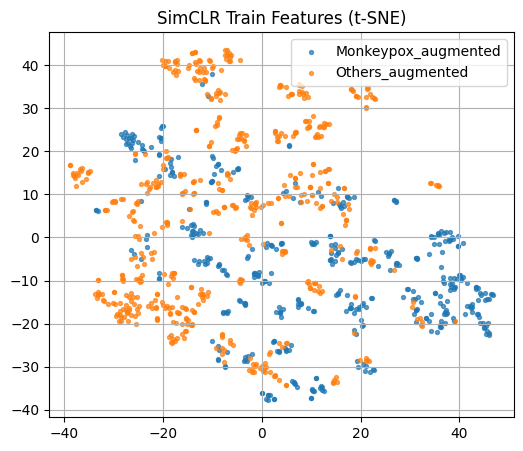

In [11]:
def extract_features(dataloader, encoder):
    encoder.eval()
    feats, labs = [], []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(DEVICE)
            h = encoder(imgs)  # [B, 2048]
            feats.append(h.cpu().numpy())
            labs.append(labels.numpy())
    feats = np.concatenate(feats, axis=0)
    labs = np.concatenate(labs, axis=0)
    return feats, labs

# Use a manageable subset for visualization to avoid memory spikes
def subset_for_vis(dataloader, max_samples=1000):
    xs, ys = [], []
    total = 0
    for imgs, labels in dataloader:
        if total >= max_samples:
            break
        take = min(imgs.size(0), max_samples - total)
        xs.append(imgs[:take])
        ys.append(labels[:take])
        total += take
    X = torch.cat(xs, dim=0)
    y = torch.cat(ys, dim=0)
    return DataLoader(list(zip(X, y)), batch_size=BATCH_SIZE_SUP, shuffle=False)

# Build a small vis set from the train_down set
vis_loader = subset_for_vis(train_down_loader, max_samples=1000)

# Reload a plain ResNet50 encoder and load weights (ensures clean .eval() model)
encoder_vis = models.resnet50(weights=None)
encoder_vis.fc = nn.Identity()
encoder_vis.load_state_dict(torch.load(os.path.join(SAVE_DIR, "simclr_resnet50_encoder.pth"), map_location=DEVICE))
encoder_vis = encoder_vis.to(DEVICE)
encoder_vis.eval()

vis_features, vis_labels = extract_features(vis_loader, encoder_vis)

# t-SNE (2D)
print("Computing t-SNE on train features...")
tsne = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30, random_state=SEED)
tsne_2d = tsne.fit_transform(vis_features)
plt.figure(figsize=(6,5))
for c in np.unique(vis_labels):
    idx = vis_labels == c
    plt.scatter(tsne_2d[idx,0], tsne_2d[idx,1], s=8, label=IDX_TO_CLASS[c], alpha=0.7)
plt.legend()
plt.title("SimCLR Train Features (t-SNE)")
plt.grid(True)
plt.show()

Computing UMAP on train features...


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


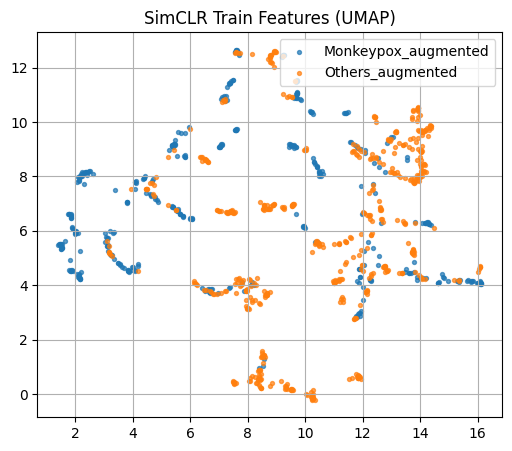

In [12]:
print("Computing UMAP on train features...")
reducer = umap.UMAP(n_components=2, random_state=SEED)
umap_2d = reducer.fit_transform(vis_features)
plt.figure(figsize=(6,5))
for c in np.unique(vis_labels):
    idx = vis_labels == c
    plt.scatter(umap_2d[idx,0], umap_2d[idx,1], s=8, label=IDX_TO_CLASS[c], alpha=0.7)
plt.legend()
plt.title("SimCLR Train Features (UMAP)")
plt.grid(True)
plt.show()

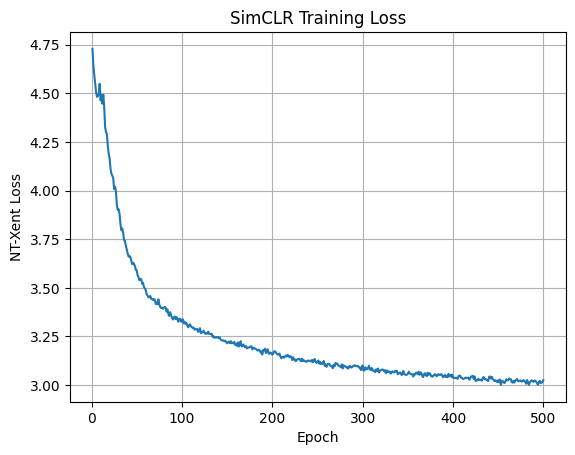

In [13]:
# SSL Loss Curve
plot_curve(ssl_loss_history, "SimCLR Training Loss", "Epoch", "NT-Xent Loss")


In [14]:
# ----------------- Downstream Linear Evaluation -----------------
# Freeze encoder, train linear classifier on train_down, validate on val_down
encoder_linear = models.resnet50(weights=None)
encoder_linear.fc = nn.Identity()
encoder_linear.load_state_dict(torch.load(os.path.join(SAVE_DIR, "simclr_resnet50_encoder.pth"), map_location=DEVICE))
encoder_linear = encoder_linear.to(DEVICE)
for p in encoder_linear.parameters():
    p.requires_grad = False
encoder_linear.eval()

classifier = nn.Linear(FEATURE_DIM, NUM_CLASSES).to(DEVICE)
opt_lin = torch.optim.Adam(classifier.parameters(), lr=LR_LINEAR)
criterion_ce = nn.CrossEntropyLoss()

lin_train_losses, lin_val_losses = [], []
lin_train_accs, lin_val_accs = [], []

print("Starting linear evaluation...")
for epoch in range(1, EPOCHS_LINEAR + 1):
    # Train classifier
    classifier.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in tqdm(train_down_loader, desc=f"Linear Epoch {epoch}/{EPOCHS_LINEAR}"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        with torch.no_grad():
            feats = encoder_linear(imgs)
        logits = classifier(feats)
        loss = criterion_ce(logits, labels)
        opt_lin.zero_grad()
        loss.backward()
        opt_lin.step()

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_loss = running_loss / total
    train_acc = correct / total
    lin_train_losses.append(train_loss)
    lin_train_accs.append(train_acc)

    # Validate
    classifier.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in val_down_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            feats = encoder_linear(imgs)
            logits = classifier(feats)
            loss = criterion_ce(logits, labels)
            running_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    val_loss = running_loss / total
    val_acc = correct / total
    lin_val_losses.append(val_loss)
    lin_val_accs.append(val_acc)
    print(f"Linear Epoch {epoch}: TrainLoss={train_loss:.4f} Acc={train_acc:.3f} | ValLoss={val_loss:.4f} Acc={val_acc:.3f}")


Starting linear evaluation...


Linear Epoch 1/500: 100%|██████████| 36/36 [00:04<00:00,  7.74it/s]


Linear Epoch 1: TrainLoss=0.5659 Acc=0.706 | ValLoss=0.4879 Acc=0.786


Linear Epoch 2/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 2: TrainLoss=0.4475 Acc=0.787 | ValLoss=0.4223 Acc=0.810


Linear Epoch 3/500: 100%|██████████| 36/36 [00:04<00:00,  7.90it/s]


Linear Epoch 3: TrainLoss=0.4164 Acc=0.809 | ValLoss=0.4028 Acc=0.816


Linear Epoch 4/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 4: TrainLoss=0.3994 Acc=0.808 | ValLoss=0.3742 Acc=0.830


Linear Epoch 5/500: 100%|██████████| 36/36 [00:04<00:00,  7.89it/s]


Linear Epoch 5: TrainLoss=0.3823 Acc=0.814 | ValLoss=0.3652 Acc=0.837


Linear Epoch 6/500: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]


Linear Epoch 6: TrainLoss=0.3697 Acc=0.823 | ValLoss=0.3436 Acc=0.852


Linear Epoch 7/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 7: TrainLoss=0.3575 Acc=0.822 | ValLoss=0.3494 Acc=0.831


Linear Epoch 8/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 8: TrainLoss=0.3478 Acc=0.837 | ValLoss=0.3342 Acc=0.847


Linear Epoch 9/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 9: TrainLoss=0.3395 Acc=0.839 | ValLoss=0.3137 Acc=0.871


Linear Epoch 10/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 10: TrainLoss=0.3336 Acc=0.841 | ValLoss=0.3111 Acc=0.859


Linear Epoch 11/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 11: TrainLoss=0.3227 Acc=0.842 | ValLoss=0.3013 Acc=0.875


Linear Epoch 12/500: 100%|██████████| 36/36 [00:04<00:00,  7.80it/s]


Linear Epoch 12: TrainLoss=0.3184 Acc=0.856 | ValLoss=0.3329 Acc=0.840


Linear Epoch 13/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 13: TrainLoss=0.3205 Acc=0.847 | ValLoss=0.2862 Acc=0.883


Linear Epoch 14/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 14: TrainLoss=0.3025 Acc=0.865 | ValLoss=0.2876 Acc=0.883


Linear Epoch 15/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 15: TrainLoss=0.2993 Acc=0.862 | ValLoss=0.2882 Acc=0.882


Linear Epoch 16/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 16: TrainLoss=0.2982 Acc=0.862 | ValLoss=0.2733 Acc=0.878


Linear Epoch 17/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 17: TrainLoss=0.2902 Acc=0.868 | ValLoss=0.2769 Acc=0.887


Linear Epoch 18/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 18: TrainLoss=0.2899 Acc=0.864 | ValLoss=0.2949 Acc=0.870


Linear Epoch 19/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 19: TrainLoss=0.2843 Acc=0.876 | ValLoss=0.2610 Acc=0.890


Linear Epoch 20/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 20: TrainLoss=0.2815 Acc=0.877 | ValLoss=0.2589 Acc=0.883


Linear Epoch 21/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 21: TrainLoss=0.2756 Acc=0.877 | ValLoss=0.2550 Acc=0.887


Linear Epoch 22/500: 100%|██████████| 36/36 [00:04<00:00,  7.89it/s]


Linear Epoch 22: TrainLoss=0.2686 Acc=0.887 | ValLoss=0.2703 Acc=0.882


Linear Epoch 23/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 23: TrainLoss=0.2712 Acc=0.882 | ValLoss=0.2497 Acc=0.894


Linear Epoch 24/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 24: TrainLoss=0.2636 Acc=0.889 | ValLoss=0.2469 Acc=0.904


Linear Epoch 25/500: 100%|██████████| 36/36 [00:04<00:00,  7.91it/s]


Linear Epoch 25: TrainLoss=0.2611 Acc=0.888 | ValLoss=0.2455 Acc=0.894


Linear Epoch 26/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 26: TrainLoss=0.2601 Acc=0.889 | ValLoss=0.2429 Acc=0.911


Linear Epoch 27/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 27: TrainLoss=0.2588 Acc=0.889 | ValLoss=0.2408 Acc=0.906


Linear Epoch 28/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 28: TrainLoss=0.2495 Acc=0.895 | ValLoss=0.2395 Acc=0.910


Linear Epoch 29/500: 100%|██████████| 36/36 [00:04<00:00,  7.75it/s]


Linear Epoch 29: TrainLoss=0.2587 Acc=0.888 | ValLoss=0.2430 Acc=0.899


Linear Epoch 30/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 30: TrainLoss=0.2582 Acc=0.887 | ValLoss=0.2341 Acc=0.897


Linear Epoch 31/500: 100%|██████████| 36/36 [00:04<00:00,  7.80it/s]


Linear Epoch 31: TrainLoss=0.2461 Acc=0.903 | ValLoss=0.2343 Acc=0.908


Linear Epoch 32/500: 100%|██████████| 36/36 [00:04<00:00,  7.60it/s]


Linear Epoch 32: TrainLoss=0.2417 Acc=0.904 | ValLoss=0.2315 Acc=0.908


Linear Epoch 33/500: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]


Linear Epoch 33: TrainLoss=0.2429 Acc=0.896 | ValLoss=0.2260 Acc=0.910


Linear Epoch 34/500: 100%|██████████| 36/36 [00:04<00:00,  7.74it/s]


Linear Epoch 34: TrainLoss=0.2381 Acc=0.905 | ValLoss=0.2226 Acc=0.922


Linear Epoch 35/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 35: TrainLoss=0.2371 Acc=0.904 | ValLoss=0.2256 Acc=0.913


Linear Epoch 36/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 36: TrainLoss=0.2325 Acc=0.912 | ValLoss=0.2338 Acc=0.911


Linear Epoch 37/500: 100%|██████████| 36/36 [00:04<00:00,  7.78it/s]


Linear Epoch 37: TrainLoss=0.2288 Acc=0.905 | ValLoss=0.2210 Acc=0.918


Linear Epoch 38/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 38: TrainLoss=0.2263 Acc=0.913 | ValLoss=0.2186 Acc=0.917


Linear Epoch 39/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 39: TrainLoss=0.2381 Acc=0.900 | ValLoss=0.2182 Acc=0.910


Linear Epoch 40/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 40: TrainLoss=0.2223 Acc=0.915 | ValLoss=0.2180 Acc=0.922


Linear Epoch 41/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 41: TrainLoss=0.2192 Acc=0.914 | ValLoss=0.2141 Acc=0.910


Linear Epoch 42/500: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]


Linear Epoch 42: TrainLoss=0.2210 Acc=0.915 | ValLoss=0.2269 Acc=0.915


Linear Epoch 43/500: 100%|██████████| 36/36 [00:04<00:00,  7.77it/s]


Linear Epoch 43: TrainLoss=0.2164 Acc=0.923 | ValLoss=0.2083 Acc=0.922


Linear Epoch 44/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 44: TrainLoss=0.2143 Acc=0.915 | ValLoss=0.2087 Acc=0.922


Linear Epoch 45/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 45: TrainLoss=0.2143 Acc=0.917 | ValLoss=0.2122 Acc=0.911


Linear Epoch 46/500: 100%|██████████| 36/36 [00:04<00:00,  7.80it/s]


Linear Epoch 46: TrainLoss=0.2108 Acc=0.923 | ValLoss=0.2117 Acc=0.917


Linear Epoch 47/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 47: TrainLoss=0.2174 Acc=0.905 | ValLoss=0.2052 Acc=0.918


Linear Epoch 48/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 48: TrainLoss=0.2115 Acc=0.919 | ValLoss=0.2047 Acc=0.918


Linear Epoch 49/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 49: TrainLoss=0.2076 Acc=0.921 | ValLoss=0.2032 Acc=0.918


Linear Epoch 50/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 50: TrainLoss=0.2029 Acc=0.928 | ValLoss=0.2022 Acc=0.922


Linear Epoch 51/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 51: TrainLoss=0.2049 Acc=0.927 | ValLoss=0.1980 Acc=0.925


Linear Epoch 52/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 52: TrainLoss=0.2039 Acc=0.924 | ValLoss=0.2034 Acc=0.923


Linear Epoch 53/500: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]


Linear Epoch 53: TrainLoss=0.2021 Acc=0.924 | ValLoss=0.1961 Acc=0.925


Linear Epoch 54/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 54: TrainLoss=0.2146 Acc=0.917 | ValLoss=0.2163 Acc=0.913


Linear Epoch 55/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 55: TrainLoss=0.2040 Acc=0.925 | ValLoss=0.1946 Acc=0.927


Linear Epoch 56/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 56: TrainLoss=0.2001 Acc=0.926 | ValLoss=0.1970 Acc=0.929


Linear Epoch 57/500: 100%|██████████| 36/36 [00:04<00:00,  7.91it/s]


Linear Epoch 57: TrainLoss=0.1966 Acc=0.926 | ValLoss=0.1944 Acc=0.922


Linear Epoch 58/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 58: TrainLoss=0.1917 Acc=0.932 | ValLoss=0.1912 Acc=0.939


Linear Epoch 59/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 59: TrainLoss=0.1979 Acc=0.923 | ValLoss=0.1955 Acc=0.918


Linear Epoch 60/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 60: TrainLoss=0.1930 Acc=0.928 | ValLoss=0.1879 Acc=0.934


Linear Epoch 61/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 61: TrainLoss=0.1911 Acc=0.929 | ValLoss=0.1883 Acc=0.934


Linear Epoch 62/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 62: TrainLoss=0.1889 Acc=0.933 | ValLoss=0.1942 Acc=0.918


Linear Epoch 63/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 63: TrainLoss=0.1908 Acc=0.928 | ValLoss=0.1879 Acc=0.925


Linear Epoch 64/500: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]


Linear Epoch 64: TrainLoss=0.1911 Acc=0.931 | ValLoss=0.1862 Acc=0.934


Linear Epoch 65/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 65: TrainLoss=0.1840 Acc=0.935 | ValLoss=0.1813 Acc=0.937


Linear Epoch 66/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 66: TrainLoss=0.1826 Acc=0.935 | ValLoss=0.1823 Acc=0.936


Linear Epoch 67/500: 100%|██████████| 36/36 [00:04<00:00,  7.89it/s]


Linear Epoch 67: TrainLoss=0.1821 Acc=0.936 | ValLoss=0.2015 Acc=0.922


Linear Epoch 68/500: 100%|██████████| 36/36 [00:04<00:00,  7.79it/s]


Linear Epoch 68: TrainLoss=0.1839 Acc=0.929 | ValLoss=0.1817 Acc=0.930


Linear Epoch 69/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 69: TrainLoss=0.1800 Acc=0.938 | ValLoss=0.1844 Acc=0.934


Linear Epoch 70/500: 100%|██████████| 36/36 [00:04<00:00,  7.90it/s]


Linear Epoch 70: TrainLoss=0.1835 Acc=0.933 | ValLoss=0.1814 Acc=0.925


Linear Epoch 71/500: 100%|██████████| 36/36 [00:04<00:00,  7.90it/s]


Linear Epoch 71: TrainLoss=0.1786 Acc=0.938 | ValLoss=0.1764 Acc=0.936


Linear Epoch 72/500: 100%|██████████| 36/36 [00:04<00:00,  7.89it/s]


Linear Epoch 72: TrainLoss=0.1812 Acc=0.937 | ValLoss=0.1955 Acc=0.923


Linear Epoch 73/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 73: TrainLoss=0.1765 Acc=0.936 | ValLoss=0.1757 Acc=0.941


Linear Epoch 74/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 74: TrainLoss=0.1779 Acc=0.934 | ValLoss=0.1905 Acc=0.917


Linear Epoch 75/500: 100%|██████████| 36/36 [00:04<00:00,  7.90it/s]


Linear Epoch 75: TrainLoss=0.1800 Acc=0.933 | ValLoss=0.1745 Acc=0.943


Linear Epoch 76/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 76: TrainLoss=0.1721 Acc=0.944 | ValLoss=0.1786 Acc=0.925


Linear Epoch 77/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 77: TrainLoss=0.1731 Acc=0.937 | ValLoss=0.1786 Acc=0.941


Linear Epoch 78/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 78: TrainLoss=0.1700 Acc=0.941 | ValLoss=0.1728 Acc=0.944


Linear Epoch 79/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 79: TrainLoss=0.1672 Acc=0.945 | ValLoss=0.1740 Acc=0.939


Linear Epoch 80/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 80: TrainLoss=0.1672 Acc=0.943 | ValLoss=0.1701 Acc=0.939


Linear Epoch 81/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 81: TrainLoss=0.1678 Acc=0.943 | ValLoss=0.1825 Acc=0.923


Linear Epoch 82/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 82: TrainLoss=0.1668 Acc=0.946 | ValLoss=0.1689 Acc=0.943


Linear Epoch 83/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 83: TrainLoss=0.1648 Acc=0.944 | ValLoss=0.1708 Acc=0.932


Linear Epoch 84/500: 100%|██████████| 36/36 [00:04<00:00,  7.89it/s]


Linear Epoch 84: TrainLoss=0.1631 Acc=0.945 | ValLoss=0.1678 Acc=0.941


Linear Epoch 85/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 85: TrainLoss=0.1642 Acc=0.942 | ValLoss=0.1690 Acc=0.943


Linear Epoch 86/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 86: TrainLoss=0.1666 Acc=0.939 | ValLoss=0.1660 Acc=0.941


Linear Epoch 87/500: 100%|██████████| 36/36 [00:04<00:00,  7.89it/s]


Linear Epoch 87: TrainLoss=0.1596 Acc=0.949 | ValLoss=0.1649 Acc=0.946


Linear Epoch 88/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 88: TrainLoss=0.1594 Acc=0.946 | ValLoss=0.1676 Acc=0.948


Linear Epoch 89/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 89: TrainLoss=0.1620 Acc=0.942 | ValLoss=0.1667 Acc=0.939


Linear Epoch 90/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 90: TrainLoss=0.1592 Acc=0.946 | ValLoss=0.1848 Acc=0.936


Linear Epoch 91/500: 100%|██████████| 36/36 [00:04<00:00,  7.78it/s]


Linear Epoch 91: TrainLoss=0.1596 Acc=0.942 | ValLoss=0.1640 Acc=0.948


Linear Epoch 92/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 92: TrainLoss=0.1579 Acc=0.948 | ValLoss=0.1617 Acc=0.948


Linear Epoch 93/500: 100%|██████████| 36/36 [00:04<00:00,  7.90it/s]


Linear Epoch 93: TrainLoss=0.1574 Acc=0.945 | ValLoss=0.1665 Acc=0.937


Linear Epoch 94/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 94: TrainLoss=0.1574 Acc=0.949 | ValLoss=0.1671 Acc=0.934


Linear Epoch 95/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 95: TrainLoss=0.1538 Acc=0.949 | ValLoss=0.1599 Acc=0.951


Linear Epoch 96/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 96: TrainLoss=0.1524 Acc=0.950 | ValLoss=0.1579 Acc=0.946


Linear Epoch 97/500: 100%|██████████| 36/36 [00:04<00:00,  7.80it/s]


Linear Epoch 97: TrainLoss=0.1514 Acc=0.950 | ValLoss=0.1601 Acc=0.941


Linear Epoch 98/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 98: TrainLoss=0.1527 Acc=0.948 | ValLoss=0.1596 Acc=0.948


Linear Epoch 99/500: 100%|██████████| 36/36 [00:04<00:00,  7.90it/s]


Linear Epoch 99: TrainLoss=0.1543 Acc=0.948 | ValLoss=0.1569 Acc=0.946


Linear Epoch 100/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 100: TrainLoss=0.1495 Acc=0.951 | ValLoss=0.1574 Acc=0.950


Linear Epoch 101/500: 100%|██████████| 36/36 [00:04<00:00,  7.80it/s]


Linear Epoch 101: TrainLoss=0.1482 Acc=0.950 | ValLoss=0.1834 Acc=0.929


Linear Epoch 102/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 102: TrainLoss=0.1527 Acc=0.946 | ValLoss=0.1556 Acc=0.944


Linear Epoch 103/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 103: TrainLoss=0.1478 Acc=0.952 | ValLoss=0.1636 Acc=0.930


Linear Epoch 104/500: 100%|██████████| 36/36 [00:04<00:00,  7.89it/s]


Linear Epoch 104: TrainLoss=0.1585 Acc=0.943 | ValLoss=0.1531 Acc=0.951


Linear Epoch 105/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 105: TrainLoss=0.1601 Acc=0.941 | ValLoss=0.1545 Acc=0.944


Linear Epoch 106/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 106: TrainLoss=0.1470 Acc=0.954 | ValLoss=0.1525 Acc=0.948


Linear Epoch 107/500: 100%|██████████| 36/36 [00:04<00:00,  7.91it/s]


Linear Epoch 107: TrainLoss=0.1444 Acc=0.955 | ValLoss=0.1564 Acc=0.943


Linear Epoch 108/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 108: TrainLoss=0.1448 Acc=0.954 | ValLoss=0.1534 Acc=0.950


Linear Epoch 109/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 109: TrainLoss=0.1417 Acc=0.957 | ValLoss=0.1542 Acc=0.944


Linear Epoch 110/500: 100%|██████████| 36/36 [00:04<00:00,  7.92it/s]


Linear Epoch 110: TrainLoss=0.1413 Acc=0.957 | ValLoss=0.1510 Acc=0.943


Linear Epoch 111/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 111: TrainLoss=0.1426 Acc=0.953 | ValLoss=0.1519 Acc=0.943


Linear Epoch 112/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 112: TrainLoss=0.1402 Acc=0.954 | ValLoss=0.1487 Acc=0.953


Linear Epoch 113/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 113: TrainLoss=0.1395 Acc=0.959 | ValLoss=0.1554 Acc=0.944


Linear Epoch 114/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 114: TrainLoss=0.1421 Acc=0.954 | ValLoss=0.1558 Acc=0.950


Linear Epoch 115/500: 100%|██████████| 36/36 [00:04<00:00,  7.79it/s]


Linear Epoch 115: TrainLoss=0.1459 Acc=0.948 | ValLoss=0.1611 Acc=0.932


Linear Epoch 116/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 116: TrainLoss=0.1404 Acc=0.953 | ValLoss=0.1515 Acc=0.950


Linear Epoch 117/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 117: TrainLoss=0.1379 Acc=0.959 | ValLoss=0.1475 Acc=0.950


Linear Epoch 118/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 118: TrainLoss=0.1376 Acc=0.955 | ValLoss=0.1487 Acc=0.950


Linear Epoch 119/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 119: TrainLoss=0.1419 Acc=0.955 | ValLoss=0.1551 Acc=0.944


Linear Epoch 120/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 120: TrainLoss=0.1359 Acc=0.956 | ValLoss=0.1517 Acc=0.951


Linear Epoch 121/500: 100%|██████████| 36/36 [00:04<00:00,  7.89it/s]


Linear Epoch 121: TrainLoss=0.1352 Acc=0.958 | ValLoss=0.1474 Acc=0.948


Linear Epoch 122/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 122: TrainLoss=0.1364 Acc=0.957 | ValLoss=0.1487 Acc=0.941


Linear Epoch 123/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 123: TrainLoss=0.1397 Acc=0.952 | ValLoss=0.1453 Acc=0.950


Linear Epoch 124/500: 100%|██████████| 36/36 [00:04<00:00,  7.89it/s]


Linear Epoch 124: TrainLoss=0.1334 Acc=0.959 | ValLoss=0.1450 Acc=0.950


Linear Epoch 125/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 125: TrainLoss=0.1360 Acc=0.952 | ValLoss=0.1442 Acc=0.957


Linear Epoch 126/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 126: TrainLoss=0.1355 Acc=0.953 | ValLoss=0.1493 Acc=0.955


Linear Epoch 127/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 127: TrainLoss=0.1353 Acc=0.953 | ValLoss=0.1472 Acc=0.946


Linear Epoch 128/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 128: TrainLoss=0.1380 Acc=0.954 | ValLoss=0.1564 Acc=0.948


Linear Epoch 129/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 129: TrainLoss=0.1313 Acc=0.960 | ValLoss=0.1425 Acc=0.953


Linear Epoch 130/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 130: TrainLoss=0.1323 Acc=0.958 | ValLoss=0.1451 Acc=0.951


Linear Epoch 131/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 131: TrainLoss=0.1355 Acc=0.953 | ValLoss=0.1447 Acc=0.953


Linear Epoch 132/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 132: TrainLoss=0.1287 Acc=0.958 | ValLoss=0.1460 Acc=0.948


Linear Epoch 133/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 133: TrainLoss=0.1298 Acc=0.957 | ValLoss=0.1449 Acc=0.953


Linear Epoch 134/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 134: TrainLoss=0.1283 Acc=0.955 | ValLoss=0.1473 Acc=0.944


Linear Epoch 135/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 135: TrainLoss=0.1328 Acc=0.957 | ValLoss=0.1432 Acc=0.951


Linear Epoch 136/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 136: TrainLoss=0.1271 Acc=0.962 | ValLoss=0.1468 Acc=0.955


Linear Epoch 137/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 137: TrainLoss=0.1259 Acc=0.962 | ValLoss=0.1418 Acc=0.948


Linear Epoch 138/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 138: TrainLoss=0.1266 Acc=0.961 | ValLoss=0.1429 Acc=0.955


Linear Epoch 139/500: 100%|██████████| 36/36 [00:04<00:00,  7.90it/s]


Linear Epoch 139: TrainLoss=0.1308 Acc=0.958 | ValLoss=0.1403 Acc=0.951


Linear Epoch 140/500: 100%|██████████| 36/36 [00:04<00:00,  7.90it/s]


Linear Epoch 140: TrainLoss=0.1253 Acc=0.959 | ValLoss=0.1483 Acc=0.950


Linear Epoch 141/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 141: TrainLoss=0.1254 Acc=0.958 | ValLoss=0.1386 Acc=0.955


Linear Epoch 142/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 142: TrainLoss=0.1272 Acc=0.963 | ValLoss=0.1394 Acc=0.950


Linear Epoch 143/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 143: TrainLoss=0.1233 Acc=0.961 | ValLoss=0.1430 Acc=0.944


Linear Epoch 144/500: 100%|██████████| 36/36 [00:04<00:00,  7.91it/s]


Linear Epoch 144: TrainLoss=0.1213 Acc=0.964 | ValLoss=0.1381 Acc=0.951


Linear Epoch 145/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 145: TrainLoss=0.1248 Acc=0.959 | ValLoss=0.1387 Acc=0.953


Linear Epoch 146/500: 100%|██████████| 36/36 [00:04<00:00,  7.89it/s]


Linear Epoch 146: TrainLoss=0.1217 Acc=0.965 | ValLoss=0.1396 Acc=0.950


Linear Epoch 147/500: 100%|██████████| 36/36 [00:04<00:00,  7.91it/s]


Linear Epoch 147: TrainLoss=0.1253 Acc=0.961 | ValLoss=0.1398 Acc=0.950


Linear Epoch 148/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 148: TrainLoss=0.1287 Acc=0.956 | ValLoss=0.1490 Acc=0.944


Linear Epoch 149/500: 100%|██████████| 36/36 [00:04<00:00,  7.91it/s]


Linear Epoch 149: TrainLoss=0.1177 Acc=0.965 | ValLoss=0.1355 Acc=0.951


Linear Epoch 150/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 150: TrainLoss=0.1208 Acc=0.964 | ValLoss=0.1472 Acc=0.948


Linear Epoch 151/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 151: TrainLoss=0.1242 Acc=0.957 | ValLoss=0.1362 Acc=0.957


Linear Epoch 152/500: 100%|██████████| 36/36 [00:04<00:00,  7.89it/s]


Linear Epoch 152: TrainLoss=0.1181 Acc=0.964 | ValLoss=0.1352 Acc=0.955


Linear Epoch 153/500: 100%|██████████| 36/36 [00:04<00:00,  7.90it/s]


Linear Epoch 153: TrainLoss=0.1203 Acc=0.962 | ValLoss=0.1340 Acc=0.955


Linear Epoch 154/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 154: TrainLoss=0.1194 Acc=0.962 | ValLoss=0.1346 Acc=0.950


Linear Epoch 155/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 155: TrainLoss=0.1223 Acc=0.959 | ValLoss=0.1431 Acc=0.955


Linear Epoch 156/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 156: TrainLoss=0.1206 Acc=0.963 | ValLoss=0.1314 Acc=0.957


Linear Epoch 157/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 157: TrainLoss=0.1185 Acc=0.962 | ValLoss=0.1332 Acc=0.960


Linear Epoch 158/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 158: TrainLoss=0.1191 Acc=0.965 | ValLoss=0.1331 Acc=0.955


Linear Epoch 159/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 159: TrainLoss=0.1145 Acc=0.965 | ValLoss=0.1361 Acc=0.948


Linear Epoch 160/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 160: TrainLoss=0.1132 Acc=0.967 | ValLoss=0.1311 Acc=0.955


Linear Epoch 161/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 161: TrainLoss=0.1136 Acc=0.969 | ValLoss=0.1323 Acc=0.957


Linear Epoch 162/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 162: TrainLoss=0.1129 Acc=0.967 | ValLoss=0.1355 Acc=0.953


Linear Epoch 163/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 163: TrainLoss=0.1132 Acc=0.967 | ValLoss=0.1348 Acc=0.957


Linear Epoch 164/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 164: TrainLoss=0.1159 Acc=0.965 | ValLoss=0.1331 Acc=0.951


Linear Epoch 165/500: 100%|██████████| 36/36 [00:04<00:00,  7.69it/s]


Linear Epoch 165: TrainLoss=0.1143 Acc=0.964 | ValLoss=0.1397 Acc=0.950


Linear Epoch 166/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 166: TrainLoss=0.1125 Acc=0.966 | ValLoss=0.1303 Acc=0.963


Linear Epoch 167/500: 100%|██████████| 36/36 [00:04<00:00,  7.89it/s]


Linear Epoch 167: TrainLoss=0.1127 Acc=0.969 | ValLoss=0.1446 Acc=0.951


Linear Epoch 168/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 168: TrainLoss=0.1157 Acc=0.965 | ValLoss=0.1308 Acc=0.958


Linear Epoch 169/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 169: TrainLoss=0.1122 Acc=0.968 | ValLoss=0.1291 Acc=0.960


Linear Epoch 170/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 170: TrainLoss=0.1099 Acc=0.970 | ValLoss=0.1289 Acc=0.957


Linear Epoch 171/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 171: TrainLoss=0.1139 Acc=0.966 | ValLoss=0.1366 Acc=0.955


Linear Epoch 172/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 172: TrainLoss=0.1091 Acc=0.969 | ValLoss=0.1261 Acc=0.957


Linear Epoch 173/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 173: TrainLoss=0.1105 Acc=0.968 | ValLoss=0.1267 Acc=0.967


Linear Epoch 174/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 174: TrainLoss=0.1088 Acc=0.967 | ValLoss=0.1258 Acc=0.960


Linear Epoch 175/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 175: TrainLoss=0.1082 Acc=0.971 | ValLoss=0.1274 Acc=0.960


Linear Epoch 176/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 176: TrainLoss=0.1089 Acc=0.967 | ValLoss=0.1272 Acc=0.957


Linear Epoch 177/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 177: TrainLoss=0.1074 Acc=0.970 | ValLoss=0.1324 Acc=0.957


Linear Epoch 178/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 178: TrainLoss=0.1083 Acc=0.968 | ValLoss=0.1318 Acc=0.957


Linear Epoch 179/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 179: TrainLoss=0.1065 Acc=0.972 | ValLoss=0.1270 Acc=0.963


Linear Epoch 180/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 180: TrainLoss=0.1061 Acc=0.973 | ValLoss=0.1302 Acc=0.960


Linear Epoch 181/500: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]


Linear Epoch 181: TrainLoss=0.1059 Acc=0.973 | ValLoss=0.1239 Acc=0.958


Linear Epoch 182/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 182: TrainLoss=0.1042 Acc=0.972 | ValLoss=0.1321 Acc=0.955


Linear Epoch 183/500: 100%|██████████| 36/36 [00:04<00:00,  7.80it/s]


Linear Epoch 183: TrainLoss=0.1090 Acc=0.966 | ValLoss=0.1246 Acc=0.957


Linear Epoch 184/500: 100%|██████████| 36/36 [00:04<00:00,  7.75it/s]


Linear Epoch 184: TrainLoss=0.1043 Acc=0.971 | ValLoss=0.1242 Acc=0.957


Linear Epoch 185/500: 100%|██████████| 36/36 [00:04<00:00,  7.79it/s]


Linear Epoch 185: TrainLoss=0.1062 Acc=0.969 | ValLoss=0.1261 Acc=0.962


Linear Epoch 186/500: 100%|██████████| 36/36 [00:04<00:00,  7.79it/s]


Linear Epoch 186: TrainLoss=0.1072 Acc=0.969 | ValLoss=0.1271 Acc=0.960


Linear Epoch 187/500: 100%|██████████| 36/36 [00:04<00:00,  7.75it/s]


Linear Epoch 187: TrainLoss=0.1050 Acc=0.968 | ValLoss=0.1252 Acc=0.957


Linear Epoch 188/500: 100%|██████████| 36/36 [00:04<00:00,  7.79it/s]


Linear Epoch 188: TrainLoss=0.1029 Acc=0.970 | ValLoss=0.1330 Acc=0.950


Linear Epoch 189/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 189: TrainLoss=0.1041 Acc=0.970 | ValLoss=0.1224 Acc=0.962


Linear Epoch 190/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 190: TrainLoss=0.1004 Acc=0.973 | ValLoss=0.1247 Acc=0.958


Linear Epoch 191/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 191: TrainLoss=0.1020 Acc=0.973 | ValLoss=0.1242 Acc=0.960


Linear Epoch 192/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 192: TrainLoss=0.1061 Acc=0.971 | ValLoss=0.1244 Acc=0.960


Linear Epoch 193/500: 100%|██████████| 36/36 [00:04<00:00,  7.90it/s]


Linear Epoch 193: TrainLoss=0.1055 Acc=0.967 | ValLoss=0.1225 Acc=0.958


Linear Epoch 194/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 194: TrainLoss=0.1013 Acc=0.972 | ValLoss=0.1214 Acc=0.958


Linear Epoch 195/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 195: TrainLoss=0.0991 Acc=0.973 | ValLoss=0.1294 Acc=0.957


Linear Epoch 196/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 196: TrainLoss=0.1004 Acc=0.970 | ValLoss=0.1244 Acc=0.957


Linear Epoch 197/500: 100%|██████████| 36/36 [00:04<00:00,  7.78it/s]


Linear Epoch 197: TrainLoss=0.1043 Acc=0.968 | ValLoss=0.1218 Acc=0.965


Linear Epoch 198/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 198: TrainLoss=0.1021 Acc=0.971 | ValLoss=0.1351 Acc=0.944


Linear Epoch 199/500: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]


Linear Epoch 199: TrainLoss=0.1000 Acc=0.967 | ValLoss=0.1216 Acc=0.955


Linear Epoch 200/500: 100%|██████████| 36/36 [00:04<00:00,  7.77it/s]


Linear Epoch 200: TrainLoss=0.1003 Acc=0.970 | ValLoss=0.1209 Acc=0.963


Linear Epoch 201/500: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]


Linear Epoch 201: TrainLoss=0.0971 Acc=0.973 | ValLoss=0.1222 Acc=0.962


Linear Epoch 202/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 202: TrainLoss=0.0986 Acc=0.974 | ValLoss=0.1236 Acc=0.957


Linear Epoch 203/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 203: TrainLoss=0.0975 Acc=0.971 | ValLoss=0.1196 Acc=0.958


Linear Epoch 204/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 204: TrainLoss=0.0992 Acc=0.970 | ValLoss=0.1211 Acc=0.962


Linear Epoch 205/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 205: TrainLoss=0.0968 Acc=0.972 | ValLoss=0.1217 Acc=0.962


Linear Epoch 206/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 206: TrainLoss=0.0953 Acc=0.974 | ValLoss=0.1182 Acc=0.962


Linear Epoch 207/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 207: TrainLoss=0.0960 Acc=0.975 | ValLoss=0.1261 Acc=0.957


Linear Epoch 208/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 208: TrainLoss=0.0958 Acc=0.976 | ValLoss=0.1217 Acc=0.960


Linear Epoch 209/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 209: TrainLoss=0.0949 Acc=0.975 | ValLoss=0.1202 Acc=0.958


Linear Epoch 210/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 210: TrainLoss=0.0941 Acc=0.973 | ValLoss=0.1197 Acc=0.960


Linear Epoch 211/500: 100%|██████████| 36/36 [00:04<00:00,  7.90it/s]


Linear Epoch 211: TrainLoss=0.0948 Acc=0.974 | ValLoss=0.1207 Acc=0.957


Linear Epoch 212/500: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]


Linear Epoch 212: TrainLoss=0.0951 Acc=0.972 | ValLoss=0.1177 Acc=0.960


Linear Epoch 213/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 213: TrainLoss=0.0940 Acc=0.974 | ValLoss=0.1236 Acc=0.958


Linear Epoch 214/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 214: TrainLoss=0.0950 Acc=0.975 | ValLoss=0.1488 Acc=0.948


Linear Epoch 215/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 215: TrainLoss=0.0989 Acc=0.970 | ValLoss=0.1180 Acc=0.958


Linear Epoch 216/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 216: TrainLoss=0.0925 Acc=0.976 | ValLoss=0.1177 Acc=0.960


Linear Epoch 217/500: 100%|██████████| 36/36 [00:04<00:00,  7.77it/s]


Linear Epoch 217: TrainLoss=0.0941 Acc=0.975 | ValLoss=0.1191 Acc=0.960


Linear Epoch 218/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 218: TrainLoss=0.0956 Acc=0.975 | ValLoss=0.1162 Acc=0.960


Linear Epoch 219/500: 100%|██████████| 36/36 [00:04<00:00,  7.92it/s]


Linear Epoch 219: TrainLoss=0.0915 Acc=0.976 | ValLoss=0.1170 Acc=0.958


Linear Epoch 220/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 220: TrainLoss=0.0906 Acc=0.974 | ValLoss=0.1208 Acc=0.962


Linear Epoch 221/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 221: TrainLoss=0.0913 Acc=0.975 | ValLoss=0.1156 Acc=0.962


Linear Epoch 222/500: 100%|██████████| 36/36 [00:04<00:00,  7.76it/s]


Linear Epoch 222: TrainLoss=0.0933 Acc=0.971 | ValLoss=0.1163 Acc=0.963


Linear Epoch 223/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 223: TrainLoss=0.0898 Acc=0.978 | ValLoss=0.1160 Acc=0.962


Linear Epoch 224/500: 100%|██████████| 36/36 [00:04<00:00,  7.79it/s]


Linear Epoch 224: TrainLoss=0.0900 Acc=0.975 | ValLoss=0.1153 Acc=0.965


Linear Epoch 225/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 225: TrainLoss=0.0906 Acc=0.973 | ValLoss=0.1171 Acc=0.960


Linear Epoch 226/500: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]


Linear Epoch 226: TrainLoss=0.0891 Acc=0.975 | ValLoss=0.1164 Acc=0.960


Linear Epoch 227/500: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]


Linear Epoch 227: TrainLoss=0.0918 Acc=0.973 | ValLoss=0.1168 Acc=0.962


Linear Epoch 228/500: 100%|██████████| 36/36 [00:04<00:00,  7.91it/s]


Linear Epoch 228: TrainLoss=0.0918 Acc=0.973 | ValLoss=0.1154 Acc=0.960


Linear Epoch 229/500: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]


Linear Epoch 229: TrainLoss=0.0969 Acc=0.972 | ValLoss=0.1236 Acc=0.953


Linear Epoch 230/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 230: TrainLoss=0.0974 Acc=0.974 | ValLoss=0.1156 Acc=0.957


Linear Epoch 231/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 231: TrainLoss=0.0886 Acc=0.976 | ValLoss=0.1135 Acc=0.960


Linear Epoch 232/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 232: TrainLoss=0.0889 Acc=0.976 | ValLoss=0.1134 Acc=0.960


Linear Epoch 233/500: 100%|██████████| 36/36 [00:04<00:00,  7.80it/s]


Linear Epoch 233: TrainLoss=0.0879 Acc=0.976 | ValLoss=0.1153 Acc=0.962


Linear Epoch 234/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 234: TrainLoss=0.0885 Acc=0.977 | ValLoss=0.1136 Acc=0.960


Linear Epoch 235/500: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]


Linear Epoch 235: TrainLoss=0.0929 Acc=0.972 | ValLoss=0.1343 Acc=0.958


Linear Epoch 236/500: 100%|██████████| 36/36 [00:04<00:00,  7.79it/s]


Linear Epoch 236: TrainLoss=0.0917 Acc=0.972 | ValLoss=0.1301 Acc=0.955


Linear Epoch 237/500: 100%|██████████| 36/36 [00:04<00:00,  7.80it/s]


Linear Epoch 237: TrainLoss=0.0870 Acc=0.977 | ValLoss=0.1119 Acc=0.962


Linear Epoch 238/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 238: TrainLoss=0.0859 Acc=0.978 | ValLoss=0.1113 Acc=0.963


Linear Epoch 239/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 239: TrainLoss=0.0864 Acc=0.976 | ValLoss=0.1144 Acc=0.967


Linear Epoch 240/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 240: TrainLoss=0.0851 Acc=0.976 | ValLoss=0.1124 Acc=0.960


Linear Epoch 241/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 241: TrainLoss=0.0873 Acc=0.976 | ValLoss=0.1144 Acc=0.960


Linear Epoch 242/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 242: TrainLoss=0.0883 Acc=0.976 | ValLoss=0.1202 Acc=0.962


Linear Epoch 243/500: 100%|██████████| 36/36 [00:04<00:00,  7.90it/s]


Linear Epoch 243: TrainLoss=0.0910 Acc=0.972 | ValLoss=0.1107 Acc=0.958


Linear Epoch 244/500: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]


Linear Epoch 244: TrainLoss=0.0874 Acc=0.976 | ValLoss=0.1108 Acc=0.965


Linear Epoch 245/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 245: TrainLoss=0.0849 Acc=0.978 | ValLoss=0.1103 Acc=0.963


Linear Epoch 246/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 246: TrainLoss=0.0901 Acc=0.975 | ValLoss=0.1119 Acc=0.962


Linear Epoch 247/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 247: TrainLoss=0.0840 Acc=0.977 | ValLoss=0.1107 Acc=0.963


Linear Epoch 248/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 248: TrainLoss=0.0840 Acc=0.980 | ValLoss=0.1104 Acc=0.963


Linear Epoch 249/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 249: TrainLoss=0.0818 Acc=0.978 | ValLoss=0.1123 Acc=0.957


Linear Epoch 250/500: 100%|██████████| 36/36 [00:04<00:00,  7.90it/s]


Linear Epoch 250: TrainLoss=0.0892 Acc=0.971 | ValLoss=0.1116 Acc=0.963


Linear Epoch 251/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 251: TrainLoss=0.0830 Acc=0.979 | ValLoss=0.1120 Acc=0.958


Linear Epoch 252/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 252: TrainLoss=0.0862 Acc=0.975 | ValLoss=0.1108 Acc=0.963


Linear Epoch 253/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 253: TrainLoss=0.0826 Acc=0.978 | ValLoss=0.1121 Acc=0.965


Linear Epoch 254/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 254: TrainLoss=0.0810 Acc=0.978 | ValLoss=0.1129 Acc=0.958


Linear Epoch 255/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 255: TrainLoss=0.0821 Acc=0.979 | ValLoss=0.1142 Acc=0.960


Linear Epoch 256/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 256: TrainLoss=0.0834 Acc=0.977 | ValLoss=0.1116 Acc=0.958


Linear Epoch 257/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 257: TrainLoss=0.0820 Acc=0.976 | ValLoss=0.1110 Acc=0.958


Linear Epoch 258/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 258: TrainLoss=0.0809 Acc=0.977 | ValLoss=0.1125 Acc=0.965


Linear Epoch 259/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 259: TrainLoss=0.0849 Acc=0.976 | ValLoss=0.1108 Acc=0.963


Linear Epoch 260/500: 100%|██████████| 36/36 [00:04<00:00,  7.90it/s]


Linear Epoch 260: TrainLoss=0.0806 Acc=0.980 | ValLoss=0.1087 Acc=0.962


Linear Epoch 261/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 261: TrainLoss=0.0816 Acc=0.978 | ValLoss=0.1114 Acc=0.960


Linear Epoch 262/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 262: TrainLoss=0.0799 Acc=0.979 | ValLoss=0.1081 Acc=0.963


Linear Epoch 263/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 263: TrainLoss=0.0808 Acc=0.979 | ValLoss=0.1159 Acc=0.958


Linear Epoch 264/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 264: TrainLoss=0.0811 Acc=0.977 | ValLoss=0.1080 Acc=0.962


Linear Epoch 265/500: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]


Linear Epoch 265: TrainLoss=0.0795 Acc=0.979 | ValLoss=0.1167 Acc=0.958


Linear Epoch 266/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 266: TrainLoss=0.0851 Acc=0.977 | ValLoss=0.1159 Acc=0.962


Linear Epoch 267/500: 100%|██████████| 36/36 [00:04<00:00,  7.67it/s]


Linear Epoch 267: TrainLoss=0.0793 Acc=0.978 | ValLoss=0.1079 Acc=0.963


Linear Epoch 268/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 268: TrainLoss=0.0786 Acc=0.977 | ValLoss=0.1098 Acc=0.965


Linear Epoch 269/500: 100%|██████████| 36/36 [00:04<00:00,  7.79it/s]


Linear Epoch 269: TrainLoss=0.0779 Acc=0.979 | ValLoss=0.1102 Acc=0.960


Linear Epoch 270/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 270: TrainLoss=0.0794 Acc=0.978 | ValLoss=0.1134 Acc=0.960


Linear Epoch 271/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 271: TrainLoss=0.0794 Acc=0.978 | ValLoss=0.1084 Acc=0.963


Linear Epoch 272/500: 100%|██████████| 36/36 [00:04<00:00,  7.77it/s]


Linear Epoch 272: TrainLoss=0.0785 Acc=0.979 | ValLoss=0.1070 Acc=0.965


Linear Epoch 273/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 273: TrainLoss=0.0814 Acc=0.975 | ValLoss=0.1063 Acc=0.963


Linear Epoch 274/500: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]


Linear Epoch 274: TrainLoss=0.0781 Acc=0.978 | ValLoss=0.1063 Acc=0.960


Linear Epoch 275/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 275: TrainLoss=0.0784 Acc=0.976 | ValLoss=0.1067 Acc=0.965


Linear Epoch 276/500: 100%|██████████| 36/36 [00:04<00:00,  7.89it/s]


Linear Epoch 276: TrainLoss=0.0787 Acc=0.979 | ValLoss=0.1091 Acc=0.963


Linear Epoch 277/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 277: TrainLoss=0.0774 Acc=0.979 | ValLoss=0.1097 Acc=0.960


Linear Epoch 278/500: 100%|██████████| 36/36 [00:04<00:00,  7.76it/s]


Linear Epoch 278: TrainLoss=0.0757 Acc=0.980 | ValLoss=0.1094 Acc=0.960


Linear Epoch 279/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 279: TrainLoss=0.0756 Acc=0.981 | ValLoss=0.1102 Acc=0.962


Linear Epoch 280/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 280: TrainLoss=0.0752 Acc=0.980 | ValLoss=0.1079 Acc=0.962


Linear Epoch 281/500: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]


Linear Epoch 281: TrainLoss=0.0780 Acc=0.977 | ValLoss=0.1083 Acc=0.960


Linear Epoch 282/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 282: TrainLoss=0.0737 Acc=0.983 | ValLoss=0.1104 Acc=0.962


Linear Epoch 283/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 283: TrainLoss=0.0753 Acc=0.981 | ValLoss=0.1050 Acc=0.965


Linear Epoch 284/500: 100%|██████████| 36/36 [00:04<00:00,  7.80it/s]


Linear Epoch 284: TrainLoss=0.0751 Acc=0.981 | ValLoss=0.1069 Acc=0.962


Linear Epoch 285/500: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]


Linear Epoch 285: TrainLoss=0.0744 Acc=0.980 | ValLoss=0.1058 Acc=0.962


Linear Epoch 286/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 286: TrainLoss=0.0759 Acc=0.979 | ValLoss=0.1067 Acc=0.962


Linear Epoch 287/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 287: TrainLoss=0.0741 Acc=0.979 | ValLoss=0.1056 Acc=0.963


Linear Epoch 288/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 288: TrainLoss=0.0753 Acc=0.980 | ValLoss=0.1076 Acc=0.962


Linear Epoch 289/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 289: TrainLoss=0.0767 Acc=0.982 | ValLoss=0.1118 Acc=0.962


Linear Epoch 290/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 290: TrainLoss=0.0733 Acc=0.980 | ValLoss=0.1036 Acc=0.965


Linear Epoch 291/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 291: TrainLoss=0.0749 Acc=0.978 | ValLoss=0.1061 Acc=0.963


Linear Epoch 292/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 292: TrainLoss=0.0730 Acc=0.981 | ValLoss=0.1071 Acc=0.962


Linear Epoch 293/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 293: TrainLoss=0.0735 Acc=0.980 | ValLoss=0.1055 Acc=0.960


Linear Epoch 294/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 294: TrainLoss=0.0744 Acc=0.979 | ValLoss=0.1092 Acc=0.962


Linear Epoch 295/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 295: TrainLoss=0.0735 Acc=0.982 | ValLoss=0.1043 Acc=0.960


Linear Epoch 296/500: 100%|██████████| 36/36 [00:04<00:00,  7.90it/s]


Linear Epoch 296: TrainLoss=0.0727 Acc=0.979 | ValLoss=0.1052 Acc=0.963


Linear Epoch 297/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 297: TrainLoss=0.0716 Acc=0.981 | ValLoss=0.1065 Acc=0.958


Linear Epoch 298/500: 100%|██████████| 36/36 [00:04<00:00,  7.91it/s]


Linear Epoch 298: TrainLoss=0.0720 Acc=0.980 | ValLoss=0.1118 Acc=0.963


Linear Epoch 299/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 299: TrainLoss=0.0720 Acc=0.982 | ValLoss=0.1026 Acc=0.963


Linear Epoch 300/500: 100%|██████████| 36/36 [00:04<00:00,  7.92it/s]


Linear Epoch 300: TrainLoss=0.0709 Acc=0.982 | ValLoss=0.1039 Acc=0.965


Linear Epoch 301/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 301: TrainLoss=0.0741 Acc=0.979 | ValLoss=0.1075 Acc=0.962


Linear Epoch 302/500: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]


Linear Epoch 302: TrainLoss=0.0716 Acc=0.983 | ValLoss=0.1035 Acc=0.965


Linear Epoch 303/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 303: TrainLoss=0.0712 Acc=0.983 | ValLoss=0.1106 Acc=0.962


Linear Epoch 304/500: 100%|██████████| 36/36 [00:04<00:00,  7.90it/s]


Linear Epoch 304: TrainLoss=0.0725 Acc=0.980 | ValLoss=0.1032 Acc=0.963


Linear Epoch 305/500: 100%|██████████| 36/36 [00:04<00:00,  7.89it/s]


Linear Epoch 305: TrainLoss=0.0705 Acc=0.982 | ValLoss=0.1020 Acc=0.965


Linear Epoch 306/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 306: TrainLoss=0.0707 Acc=0.982 | ValLoss=0.1050 Acc=0.962


Linear Epoch 307/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 307: TrainLoss=0.0697 Acc=0.982 | ValLoss=0.1026 Acc=0.960


Linear Epoch 308/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 308: TrainLoss=0.0718 Acc=0.983 | ValLoss=0.1066 Acc=0.960


Linear Epoch 309/500: 100%|██████████| 36/36 [00:04<00:00,  7.91it/s]


Linear Epoch 309: TrainLoss=0.0693 Acc=0.981 | ValLoss=0.1088 Acc=0.962


Linear Epoch 310/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 310: TrainLoss=0.0704 Acc=0.982 | ValLoss=0.1017 Acc=0.962


Linear Epoch 311/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 311: TrainLoss=0.0697 Acc=0.982 | ValLoss=0.1012 Acc=0.965


Linear Epoch 312/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 312: TrainLoss=0.0686 Acc=0.984 | ValLoss=0.1064 Acc=0.960


Linear Epoch 313/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 313: TrainLoss=0.0694 Acc=0.981 | ValLoss=0.1041 Acc=0.962


Linear Epoch 314/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 314: TrainLoss=0.0701 Acc=0.982 | ValLoss=0.1058 Acc=0.963


Linear Epoch 315/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 315: TrainLoss=0.0685 Acc=0.982 | ValLoss=0.1007 Acc=0.962


Linear Epoch 316/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 316: TrainLoss=0.0683 Acc=0.982 | ValLoss=0.1006 Acc=0.960


Linear Epoch 317/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 317: TrainLoss=0.0703 Acc=0.980 | ValLoss=0.1086 Acc=0.963


Linear Epoch 318/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 318: TrainLoss=0.0744 Acc=0.982 | ValLoss=0.1214 Acc=0.958


Linear Epoch 319/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 319: TrainLoss=0.0721 Acc=0.981 | ValLoss=0.1007 Acc=0.965


Linear Epoch 320/500: 100%|██████████| 36/36 [00:04<00:00,  7.80it/s]


Linear Epoch 320: TrainLoss=0.0681 Acc=0.983 | ValLoss=0.1032 Acc=0.962


Linear Epoch 321/500: 100%|██████████| 36/36 [00:04<00:00,  7.90it/s]


Linear Epoch 321: TrainLoss=0.0684 Acc=0.982 | ValLoss=0.0998 Acc=0.963


Linear Epoch 322/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 322: TrainLoss=0.0682 Acc=0.984 | ValLoss=0.1098 Acc=0.963


Linear Epoch 323/500: 100%|██████████| 36/36 [00:04<00:00,  7.92it/s]


Linear Epoch 323: TrainLoss=0.0666 Acc=0.983 | ValLoss=0.1031 Acc=0.967


Linear Epoch 324/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 324: TrainLoss=0.0666 Acc=0.983 | ValLoss=0.1008 Acc=0.963


Linear Epoch 325/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 325: TrainLoss=0.0669 Acc=0.984 | ValLoss=0.1017 Acc=0.960


Linear Epoch 326/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 326: TrainLoss=0.0671 Acc=0.980 | ValLoss=0.1083 Acc=0.965


Linear Epoch 327/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 327: TrainLoss=0.0691 Acc=0.982 | ValLoss=0.1116 Acc=0.962


Linear Epoch 328/500: 100%|██████████| 36/36 [00:04<00:00,  7.92it/s]


Linear Epoch 328: TrainLoss=0.0696 Acc=0.980 | ValLoss=0.1058 Acc=0.958


Linear Epoch 329/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 329: TrainLoss=0.0666 Acc=0.984 | ValLoss=0.1159 Acc=0.965


Linear Epoch 330/500: 100%|██████████| 36/36 [00:04<00:00,  7.80it/s]


Linear Epoch 330: TrainLoss=0.0683 Acc=0.981 | ValLoss=0.1057 Acc=0.958


Linear Epoch 331/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 331: TrainLoss=0.0656 Acc=0.984 | ValLoss=0.0998 Acc=0.965


Linear Epoch 332/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 332: TrainLoss=0.0695 Acc=0.980 | ValLoss=0.1002 Acc=0.962


Linear Epoch 333/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 333: TrainLoss=0.0703 Acc=0.981 | ValLoss=0.1010 Acc=0.967


Linear Epoch 334/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 334: TrainLoss=0.0659 Acc=0.984 | ValLoss=0.0975 Acc=0.970


Linear Epoch 335/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 335: TrainLoss=0.0654 Acc=0.984 | ValLoss=0.1021 Acc=0.962


Linear Epoch 336/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 336: TrainLoss=0.0693 Acc=0.981 | ValLoss=0.1011 Acc=0.963


Linear Epoch 337/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 337: TrainLoss=0.0658 Acc=0.982 | ValLoss=0.1015 Acc=0.962


Linear Epoch 338/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 338: TrainLoss=0.0651 Acc=0.984 | ValLoss=0.1013 Acc=0.965


Linear Epoch 339/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 339: TrainLoss=0.0636 Acc=0.984 | ValLoss=0.1009 Acc=0.963


Linear Epoch 340/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 340: TrainLoss=0.0647 Acc=0.984 | ValLoss=0.1002 Acc=0.967


Linear Epoch 341/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 341: TrainLoss=0.0635 Acc=0.985 | ValLoss=0.0993 Acc=0.963


Linear Epoch 342/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 342: TrainLoss=0.0626 Acc=0.985 | ValLoss=0.0977 Acc=0.962


Linear Epoch 343/500: 100%|██████████| 36/36 [00:04<00:00,  7.89it/s]


Linear Epoch 343: TrainLoss=0.0637 Acc=0.986 | ValLoss=0.0994 Acc=0.962


Linear Epoch 344/500: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]


Linear Epoch 344: TrainLoss=0.0624 Acc=0.986 | ValLoss=0.0996 Acc=0.969


Linear Epoch 345/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 345: TrainLoss=0.0632 Acc=0.984 | ValLoss=0.0988 Acc=0.963


Linear Epoch 346/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 346: TrainLoss=0.0621 Acc=0.986 | ValLoss=0.0985 Acc=0.965


Linear Epoch 347/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 347: TrainLoss=0.0621 Acc=0.984 | ValLoss=0.0982 Acc=0.969


Linear Epoch 348/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 348: TrainLoss=0.0632 Acc=0.983 | ValLoss=0.1015 Acc=0.967


Linear Epoch 349/500: 100%|██████████| 36/36 [00:04<00:00,  7.91it/s]


Linear Epoch 349: TrainLoss=0.0669 Acc=0.984 | ValLoss=0.1038 Acc=0.960


Linear Epoch 350/500: 100%|██████████| 36/36 [00:04<00:00,  7.90it/s]


Linear Epoch 350: TrainLoss=0.0622 Acc=0.984 | ValLoss=0.1051 Acc=0.963


Linear Epoch 351/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 351: TrainLoss=0.0619 Acc=0.985 | ValLoss=0.1013 Acc=0.967


Linear Epoch 352/500: 100%|██████████| 36/36 [00:04<00:00,  7.79it/s]


Linear Epoch 352: TrainLoss=0.0606 Acc=0.986 | ValLoss=0.1051 Acc=0.958


Linear Epoch 353/500: 100%|██████████| 36/36 [00:04<00:00,  7.89it/s]


Linear Epoch 353: TrainLoss=0.0625 Acc=0.984 | ValLoss=0.0983 Acc=0.965


Linear Epoch 354/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 354: TrainLoss=0.0624 Acc=0.985 | ValLoss=0.0993 Acc=0.962


Linear Epoch 355/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 355: TrainLoss=0.0619 Acc=0.982 | ValLoss=0.0990 Acc=0.963


Linear Epoch 356/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 356: TrainLoss=0.0631 Acc=0.983 | ValLoss=0.0985 Acc=0.963


Linear Epoch 357/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 357: TrainLoss=0.0614 Acc=0.987 | ValLoss=0.1087 Acc=0.967


Linear Epoch 358/500: 100%|██████████| 36/36 [00:04<00:00,  7.94it/s]


Linear Epoch 358: TrainLoss=0.0692 Acc=0.983 | ValLoss=0.1044 Acc=0.960


Linear Epoch 359/500: 100%|██████████| 36/36 [00:04<00:00,  7.90it/s]


Linear Epoch 359: TrainLoss=0.0610 Acc=0.984 | ValLoss=0.1020 Acc=0.963


Linear Epoch 360/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 360: TrainLoss=0.0630 Acc=0.984 | ValLoss=0.1025 Acc=0.960


Linear Epoch 361/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 361: TrainLoss=0.0601 Acc=0.988 | ValLoss=0.0972 Acc=0.965


Linear Epoch 362/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 362: TrainLoss=0.0620 Acc=0.983 | ValLoss=0.0984 Acc=0.963


Linear Epoch 363/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 363: TrainLoss=0.0600 Acc=0.984 | ValLoss=0.0987 Acc=0.963


Linear Epoch 364/500: 100%|██████████| 36/36 [00:04<00:00,  7.89it/s]


Linear Epoch 364: TrainLoss=0.0615 Acc=0.984 | ValLoss=0.0992 Acc=0.963


Linear Epoch 365/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 365: TrainLoss=0.0598 Acc=0.985 | ValLoss=0.0990 Acc=0.963


Linear Epoch 366/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 366: TrainLoss=0.0592 Acc=0.985 | ValLoss=0.0982 Acc=0.963


Linear Epoch 367/500: 100%|██████████| 36/36 [00:04<00:00,  7.89it/s]


Linear Epoch 367: TrainLoss=0.0599 Acc=0.984 | ValLoss=0.0977 Acc=0.970


Linear Epoch 368/500: 100%|██████████| 36/36 [00:04<00:00,  7.92it/s]


Linear Epoch 368: TrainLoss=0.0603 Acc=0.986 | ValLoss=0.0981 Acc=0.963


Linear Epoch 369/500: 100%|██████████| 36/36 [00:04<00:00,  7.89it/s]


Linear Epoch 369: TrainLoss=0.0587 Acc=0.985 | ValLoss=0.0960 Acc=0.965


Linear Epoch 370/500: 100%|██████████| 36/36 [00:04<00:00,  7.78it/s]


Linear Epoch 370: TrainLoss=0.0586 Acc=0.986 | ValLoss=0.1005 Acc=0.963


Linear Epoch 371/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 371: TrainLoss=0.0603 Acc=0.987 | ValLoss=0.0982 Acc=0.965


Linear Epoch 372/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 372: TrainLoss=0.0593 Acc=0.986 | ValLoss=0.1004 Acc=0.965


Linear Epoch 373/500: 100%|██████████| 36/36 [00:04<00:00,  7.80it/s]


Linear Epoch 373: TrainLoss=0.0581 Acc=0.985 | ValLoss=0.1012 Acc=0.963


Linear Epoch 374/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 374: TrainLoss=0.0599 Acc=0.985 | ValLoss=0.0974 Acc=0.963


Linear Epoch 375/500: 100%|██████████| 36/36 [00:04<00:00,  7.92it/s]


Linear Epoch 375: TrainLoss=0.0585 Acc=0.986 | ValLoss=0.0965 Acc=0.967


Linear Epoch 376/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 376: TrainLoss=0.0595 Acc=0.986 | ValLoss=0.0948 Acc=0.967


Linear Epoch 377/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 377: TrainLoss=0.0579 Acc=0.986 | ValLoss=0.0983 Acc=0.965


Linear Epoch 378/500: 100%|██████████| 36/36 [00:04<00:00,  7.89it/s]


Linear Epoch 378: TrainLoss=0.0584 Acc=0.986 | ValLoss=0.0972 Acc=0.963


Linear Epoch 379/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 379: TrainLoss=0.0582 Acc=0.985 | ValLoss=0.0947 Acc=0.963


Linear Epoch 380/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 380: TrainLoss=0.0591 Acc=0.986 | ValLoss=0.1016 Acc=0.967


Linear Epoch 381/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 381: TrainLoss=0.0576 Acc=0.985 | ValLoss=0.0960 Acc=0.965


Linear Epoch 382/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 382: TrainLoss=0.0568 Acc=0.987 | ValLoss=0.0955 Acc=0.965


Linear Epoch 383/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 383: TrainLoss=0.0570 Acc=0.985 | ValLoss=0.0963 Acc=0.963


Linear Epoch 384/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 384: TrainLoss=0.0574 Acc=0.988 | ValLoss=0.1022 Acc=0.962


Linear Epoch 385/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 385: TrainLoss=0.0568 Acc=0.987 | ValLoss=0.0972 Acc=0.967


Linear Epoch 386/500: 100%|██████████| 36/36 [00:04<00:00,  7.80it/s]


Linear Epoch 386: TrainLoss=0.0600 Acc=0.987 | ValLoss=0.0999 Acc=0.967


Linear Epoch 387/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 387: TrainLoss=0.0567 Acc=0.987 | ValLoss=0.0952 Acc=0.969


Linear Epoch 388/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 388: TrainLoss=0.0567 Acc=0.987 | ValLoss=0.0932 Acc=0.965


Linear Epoch 389/500: 100%|██████████| 36/36 [00:05<00:00,  6.07it/s]


Linear Epoch 389: TrainLoss=0.0554 Acc=0.986 | ValLoss=0.0961 Acc=0.965


Linear Epoch 390/500: 100%|██████████| 36/36 [00:05<00:00,  6.49it/s]


Linear Epoch 390: TrainLoss=0.0554 Acc=0.987 | ValLoss=0.0994 Acc=0.969


Linear Epoch 391/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 391: TrainLoss=0.0555 Acc=0.987 | ValLoss=0.0966 Acc=0.960


Linear Epoch 392/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 392: TrainLoss=0.0591 Acc=0.988 | ValLoss=0.1022 Acc=0.960


Linear Epoch 393/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 393: TrainLoss=0.0558 Acc=0.987 | ValLoss=0.0988 Acc=0.960


Linear Epoch 394/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 394: TrainLoss=0.0598 Acc=0.983 | ValLoss=0.0948 Acc=0.965


Linear Epoch 395/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 395: TrainLoss=0.0543 Acc=0.989 | ValLoss=0.0980 Acc=0.963


Linear Epoch 396/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 396: TrainLoss=0.0549 Acc=0.988 | ValLoss=0.1024 Acc=0.960


Linear Epoch 397/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 397: TrainLoss=0.0563 Acc=0.984 | ValLoss=0.0950 Acc=0.965


Linear Epoch 398/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 398: TrainLoss=0.0572 Acc=0.988 | ValLoss=0.0957 Acc=0.965


Linear Epoch 399/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 399: TrainLoss=0.0543 Acc=0.987 | ValLoss=0.1017 Acc=0.960


Linear Epoch 400/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 400: TrainLoss=0.0552 Acc=0.989 | ValLoss=0.0964 Acc=0.960


Linear Epoch 401/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 401: TrainLoss=0.0543 Acc=0.987 | ValLoss=0.0981 Acc=0.967


Linear Epoch 402/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 402: TrainLoss=0.0542 Acc=0.989 | ValLoss=0.0965 Acc=0.967


Linear Epoch 403/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 403: TrainLoss=0.0572 Acc=0.986 | ValLoss=0.0946 Acc=0.963


Linear Epoch 404/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 404: TrainLoss=0.0559 Acc=0.987 | ValLoss=0.0939 Acc=0.962


Linear Epoch 405/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 405: TrainLoss=0.0582 Acc=0.986 | ValLoss=0.0966 Acc=0.963


Linear Epoch 406/500: 100%|██████████| 36/36 [00:04<00:00,  7.89it/s]


Linear Epoch 406: TrainLoss=0.0536 Acc=0.989 | ValLoss=0.0940 Acc=0.963


Linear Epoch 407/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 407: TrainLoss=0.0547 Acc=0.989 | ValLoss=0.0919 Acc=0.963


Linear Epoch 408/500: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]


Linear Epoch 408: TrainLoss=0.0544 Acc=0.989 | ValLoss=0.0964 Acc=0.969


Linear Epoch 409/500: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]


Linear Epoch 409: TrainLoss=0.0567 Acc=0.987 | ValLoss=0.0952 Acc=0.967


Linear Epoch 410/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 410: TrainLoss=0.0524 Acc=0.988 | ValLoss=0.0933 Acc=0.963


Linear Epoch 411/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 411: TrainLoss=0.0539 Acc=0.989 | ValLoss=0.0947 Acc=0.963


Linear Epoch 412/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 412: TrainLoss=0.0535 Acc=0.988 | ValLoss=0.0984 Acc=0.958


Linear Epoch 413/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 413: TrainLoss=0.0521 Acc=0.988 | ValLoss=0.0930 Acc=0.962


Linear Epoch 414/500: 100%|██████████| 36/36 [00:04<00:00,  7.80it/s]


Linear Epoch 414: TrainLoss=0.0550 Acc=0.987 | ValLoss=0.0945 Acc=0.969


Linear Epoch 415/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 415: TrainLoss=0.0550 Acc=0.987 | ValLoss=0.0969 Acc=0.967


Linear Epoch 416/500: 100%|██████████| 36/36 [00:04<00:00,  7.90it/s]


Linear Epoch 416: TrainLoss=0.0528 Acc=0.988 | ValLoss=0.0973 Acc=0.963


Linear Epoch 417/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 417: TrainLoss=0.0532 Acc=0.989 | ValLoss=0.1003 Acc=0.962


Linear Epoch 418/500: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]


Linear Epoch 418: TrainLoss=0.0539 Acc=0.986 | ValLoss=0.0955 Acc=0.967


Linear Epoch 419/500: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]


Linear Epoch 419: TrainLoss=0.0532 Acc=0.986 | ValLoss=0.0989 Acc=0.963


Linear Epoch 420/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 420: TrainLoss=0.0532 Acc=0.987 | ValLoss=0.0911 Acc=0.965


Linear Epoch 421/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 421: TrainLoss=0.0536 Acc=0.988 | ValLoss=0.0964 Acc=0.963


Linear Epoch 422/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 422: TrainLoss=0.0523 Acc=0.990 | ValLoss=0.0914 Acc=0.965


Linear Epoch 423/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 423: TrainLoss=0.0525 Acc=0.988 | ValLoss=0.0926 Acc=0.962


Linear Epoch 424/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 424: TrainLoss=0.0512 Acc=0.988 | ValLoss=0.0926 Acc=0.965


Linear Epoch 425/500: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]


Linear Epoch 425: TrainLoss=0.0508 Acc=0.989 | ValLoss=0.0939 Acc=0.967


Linear Epoch 426/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 426: TrainLoss=0.0515 Acc=0.989 | ValLoss=0.0916 Acc=0.969


Linear Epoch 427/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 427: TrainLoss=0.0516 Acc=0.991 | ValLoss=0.0933 Acc=0.963


Linear Epoch 428/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 428: TrainLoss=0.0505 Acc=0.992 | ValLoss=0.0941 Acc=0.967


Linear Epoch 429/500: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]


Linear Epoch 429: TrainLoss=0.0534 Acc=0.987 | ValLoss=0.0955 Acc=0.965


Linear Epoch 430/500: 100%|██████████| 36/36 [00:04<00:00,  7.78it/s]


Linear Epoch 430: TrainLoss=0.0498 Acc=0.990 | ValLoss=0.0940 Acc=0.967


Linear Epoch 431/500: 100%|██████████| 36/36 [00:04<00:00,  7.77it/s]


Linear Epoch 431: TrainLoss=0.0511 Acc=0.990 | ValLoss=0.0917 Acc=0.965


Linear Epoch 432/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 432: TrainLoss=0.0551 Acc=0.987 | ValLoss=0.1020 Acc=0.969


Linear Epoch 433/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 433: TrainLoss=0.0513 Acc=0.989 | ValLoss=0.0937 Acc=0.967


Linear Epoch 434/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 434: TrainLoss=0.0492 Acc=0.990 | ValLoss=0.0924 Acc=0.960


Linear Epoch 435/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 435: TrainLoss=0.0506 Acc=0.991 | ValLoss=0.0917 Acc=0.965


Linear Epoch 436/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 436: TrainLoss=0.0510 Acc=0.988 | ValLoss=0.0917 Acc=0.965


Linear Epoch 437/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 437: TrainLoss=0.0505 Acc=0.991 | ValLoss=0.0960 Acc=0.967


Linear Epoch 438/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 438: TrainLoss=0.0513 Acc=0.988 | ValLoss=0.0926 Acc=0.963


Linear Epoch 439/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 439: TrainLoss=0.0504 Acc=0.990 | ValLoss=0.0954 Acc=0.965


Linear Epoch 440/500: 100%|██████████| 36/36 [00:04<00:00,  7.90it/s]


Linear Epoch 440: TrainLoss=0.0502 Acc=0.988 | ValLoss=0.0953 Acc=0.967


Linear Epoch 441/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 441: TrainLoss=0.0504 Acc=0.988 | ValLoss=0.0942 Acc=0.965


Linear Epoch 442/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 442: TrainLoss=0.0525 Acc=0.987 | ValLoss=0.0939 Acc=0.963


Linear Epoch 443/500: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]


Linear Epoch 443: TrainLoss=0.0500 Acc=0.989 | ValLoss=0.0908 Acc=0.967


Linear Epoch 444/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 444: TrainLoss=0.0478 Acc=0.989 | ValLoss=0.0947 Acc=0.972


Linear Epoch 445/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 445: TrainLoss=0.0491 Acc=0.989 | ValLoss=0.0901 Acc=0.965


Linear Epoch 446/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 446: TrainLoss=0.0479 Acc=0.993 | ValLoss=0.0946 Acc=0.967


Linear Epoch 447/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 447: TrainLoss=0.0478 Acc=0.989 | ValLoss=0.0920 Acc=0.967


Linear Epoch 448/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 448: TrainLoss=0.0481 Acc=0.991 | ValLoss=0.0928 Acc=0.965


Linear Epoch 449/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 449: TrainLoss=0.0480 Acc=0.991 | ValLoss=0.0930 Acc=0.962


Linear Epoch 450/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 450: TrainLoss=0.0478 Acc=0.991 | ValLoss=0.0898 Acc=0.962


Linear Epoch 451/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 451: TrainLoss=0.0485 Acc=0.989 | ValLoss=0.0927 Acc=0.963


Linear Epoch 452/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 452: TrainLoss=0.0478 Acc=0.991 | ValLoss=0.0937 Acc=0.967


Linear Epoch 453/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 453: TrainLoss=0.0477 Acc=0.988 | ValLoss=0.0920 Acc=0.962


Linear Epoch 454/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 454: TrainLoss=0.0481 Acc=0.991 | ValLoss=0.0930 Acc=0.962


Linear Epoch 455/500: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]


Linear Epoch 455: TrainLoss=0.0480 Acc=0.990 | ValLoss=0.0922 Acc=0.963


Linear Epoch 456/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 456: TrainLoss=0.0470 Acc=0.991 | ValLoss=0.0917 Acc=0.963


Linear Epoch 457/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 457: TrainLoss=0.0481 Acc=0.990 | ValLoss=0.0926 Acc=0.965


Linear Epoch 458/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 458: TrainLoss=0.0475 Acc=0.992 | ValLoss=0.0944 Acc=0.965


Linear Epoch 459/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 459: TrainLoss=0.0474 Acc=0.990 | ValLoss=0.0916 Acc=0.967


Linear Epoch 460/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 460: TrainLoss=0.0474 Acc=0.989 | ValLoss=0.0910 Acc=0.963


Linear Epoch 461/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 461: TrainLoss=0.0473 Acc=0.990 | ValLoss=0.0940 Acc=0.969


Linear Epoch 462/500: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]


Linear Epoch 462: TrainLoss=0.0475 Acc=0.989 | ValLoss=0.0923 Acc=0.962


Linear Epoch 463/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 463: TrainLoss=0.0462 Acc=0.990 | ValLoss=0.0924 Acc=0.969


Linear Epoch 464/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 464: TrainLoss=0.0473 Acc=0.990 | ValLoss=0.0917 Acc=0.963


Linear Epoch 465/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 465: TrainLoss=0.0517 Acc=0.987 | ValLoss=0.0915 Acc=0.967


Linear Epoch 466/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 466: TrainLoss=0.0471 Acc=0.990 | ValLoss=0.0898 Acc=0.965


Linear Epoch 467/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 467: TrainLoss=0.0467 Acc=0.990 | ValLoss=0.0897 Acc=0.965


Linear Epoch 468/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 468: TrainLoss=0.0461 Acc=0.990 | ValLoss=0.0973 Acc=0.965


Linear Epoch 469/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 469: TrainLoss=0.0467 Acc=0.992 | ValLoss=0.0918 Acc=0.970


Linear Epoch 470/500: 100%|██████████| 36/36 [00:04<00:00,  7.79it/s]


Linear Epoch 470: TrainLoss=0.0469 Acc=0.990 | ValLoss=0.0922 Acc=0.965


Linear Epoch 471/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 471: TrainLoss=0.0456 Acc=0.992 | ValLoss=0.0921 Acc=0.965


Linear Epoch 472/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 472: TrainLoss=0.0464 Acc=0.991 | ValLoss=0.0929 Acc=0.969


Linear Epoch 473/500: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Linear Epoch 473: TrainLoss=0.0445 Acc=0.991 | ValLoss=0.0916 Acc=0.965


Linear Epoch 474/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 474: TrainLoss=0.0467 Acc=0.990 | ValLoss=0.0940 Acc=0.970


Linear Epoch 475/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 475: TrainLoss=0.0462 Acc=0.990 | ValLoss=0.0895 Acc=0.965


Linear Epoch 476/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 476: TrainLoss=0.0447 Acc=0.991 | ValLoss=0.0892 Acc=0.965


Linear Epoch 477/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 477: TrainLoss=0.0453 Acc=0.991 | ValLoss=0.0929 Acc=0.969


Linear Epoch 478/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 478: TrainLoss=0.0446 Acc=0.991 | ValLoss=0.0933 Acc=0.972


Linear Epoch 479/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 479: TrainLoss=0.0449 Acc=0.991 | ValLoss=0.0908 Acc=0.960


Linear Epoch 480/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 480: TrainLoss=0.0451 Acc=0.992 | ValLoss=0.0907 Acc=0.967


Linear Epoch 481/500: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]


Linear Epoch 481: TrainLoss=0.0455 Acc=0.990 | ValLoss=0.0915 Acc=0.970


Linear Epoch 482/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 482: TrainLoss=0.0447 Acc=0.993 | ValLoss=0.0928 Acc=0.970


Linear Epoch 483/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 483: TrainLoss=0.0451 Acc=0.991 | ValLoss=0.0921 Acc=0.965


Linear Epoch 484/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 484: TrainLoss=0.0460 Acc=0.991 | ValLoss=0.0894 Acc=0.965


Linear Epoch 485/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 485: TrainLoss=0.0450 Acc=0.993 | ValLoss=0.0900 Acc=0.963


Linear Epoch 486/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 486: TrainLoss=0.0435 Acc=0.991 | ValLoss=0.0901 Acc=0.965


Linear Epoch 487/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 487: TrainLoss=0.0444 Acc=0.991 | ValLoss=0.0942 Acc=0.969


Linear Epoch 488/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 488: TrainLoss=0.0442 Acc=0.994 | ValLoss=0.0900 Acc=0.962


Linear Epoch 489/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 489: TrainLoss=0.0439 Acc=0.990 | ValLoss=0.0942 Acc=0.963


Linear Epoch 490/500: 100%|██████████| 36/36 [00:04<00:00,  7.83it/s]


Linear Epoch 490: TrainLoss=0.0454 Acc=0.991 | ValLoss=0.0930 Acc=0.967


Linear Epoch 491/500: 100%|██████████| 36/36 [00:04<00:00,  7.78it/s]


Linear Epoch 491: TrainLoss=0.0451 Acc=0.990 | ValLoss=0.0926 Acc=0.969


Linear Epoch 492/500: 100%|██████████| 36/36 [00:04<00:00,  7.84it/s]


Linear Epoch 492: TrainLoss=0.0441 Acc=0.993 | ValLoss=0.0913 Acc=0.967


Linear Epoch 493/500: 100%|██████████| 36/36 [00:04<00:00,  7.79it/s]


Linear Epoch 493: TrainLoss=0.0430 Acc=0.993 | ValLoss=0.0898 Acc=0.965


Linear Epoch 494/500: 100%|██████████| 36/36 [00:04<00:00,  7.80it/s]


Linear Epoch 494: TrainLoss=0.0457 Acc=0.991 | ValLoss=0.0913 Acc=0.965


Linear Epoch 495/500: 100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


Linear Epoch 495: TrainLoss=0.0434 Acc=0.993 | ValLoss=0.0912 Acc=0.962


Linear Epoch 496/500: 100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


Linear Epoch 496: TrainLoss=0.0421 Acc=0.993 | ValLoss=0.0884 Acc=0.962


Linear Epoch 497/500: 100%|██████████| 36/36 [00:04<00:00,  7.78it/s]


Linear Epoch 497: TrainLoss=0.0441 Acc=0.992 | ValLoss=0.0922 Acc=0.967


Linear Epoch 498/500: 100%|██████████| 36/36 [00:04<00:00,  7.80it/s]


Linear Epoch 498: TrainLoss=0.0455 Acc=0.991 | ValLoss=0.0930 Acc=0.963


Linear Epoch 499/500: 100%|██████████| 36/36 [00:04<00:00,  7.85it/s]


Linear Epoch 499: TrainLoss=0.0452 Acc=0.991 | ValLoss=0.0928 Acc=0.965


Linear Epoch 500/500: 100%|██████████| 36/36 [00:04<00:00,  7.73it/s]


Linear Epoch 500: TrainLoss=0.0438 Acc=0.993 | ValLoss=0.0911 Acc=0.962


In [15]:
# Downstream classification report (on validation split)
val_y = np.concatenate(all_labels)
val_pred = np.concatenate(all_preds)
print("\nDownstream Validation Classification Report:")
print(classification_report(val_y, val_pred, target_names=[IDX_TO_CLASS[i] for i in range(NUM_CLASSES)]))



Downstream Validation Classification Report:
                     precision    recall  f1-score   support

Monkeypox_augmented       0.97      0.95      0.96       273
   Others_augmented       0.96      0.97      0.96       302

           accuracy                           0.96       575
          macro avg       0.96      0.96      0.96       575
       weighted avg       0.96      0.96      0.96       575



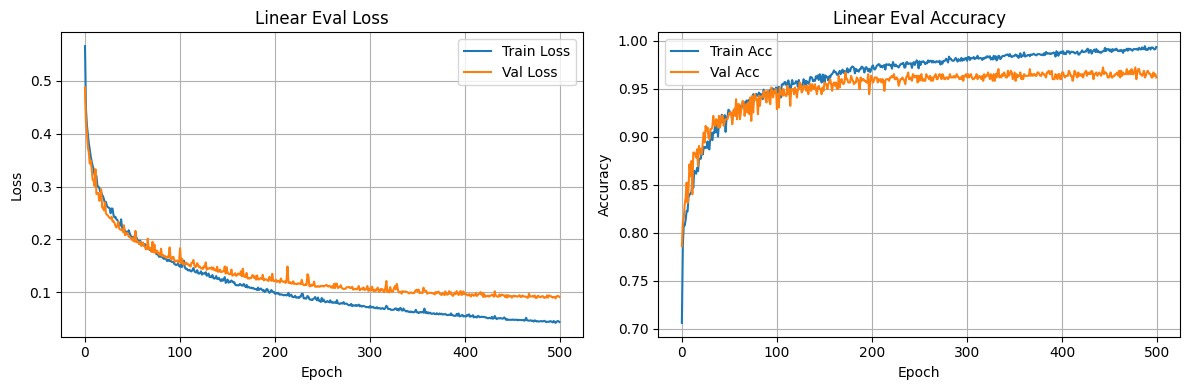

In [16]:
# Downstream curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(lin_train_losses, label='Train Loss')
plt.plot(lin_val_losses, label='Val Loss')
plt.title('Linear Eval Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True); plt.legend()

plt.subplot(1,2,2)
plt.plot(lin_train_accs, label='Train Acc')
plt.plot(lin_val_accs, label='Val Acc')
plt.title('Linear Eval Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.grid(True); plt.legend()
plt.tight_layout(); plt.show()


In [17]:
# ----------------- Testing -----------------
# Evaluate on test set (10%)
classifier.eval()
test_labels_all, test_probs_all = [], []
test_preds_all = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE); labels = labels.to(DEVICE)
        feats = encoder_linear(imgs)
        logits = classifier(feats)
        probs = F.softmax(logits, dim=1)
        preds = logits.argmax(1)

        test_labels_all.append(labels.cpu().numpy())
        test_probs_all.append(probs.cpu().numpy())
        test_preds_all.append(preds.cpu().numpy())

test_labels_all = np.concatenate(test_labels_all)
test_probs_all = np.concatenate(test_probs_all)
test_preds_all = np.concatenate(test_preds_all)

print("\nTest Classification Report:")
print(classification_report(test_labels_all, test_preds_all, target_names=[IDX_TO_CLASS[i] for i in range(NUM_CLASSES)]))



Test Classification Report:
                     precision    recall  f1-score   support

Monkeypox_augmented       0.97      0.94      0.96       145
   Others_augmented       0.96      0.98      0.97       175

           accuracy                           0.96       320
          macro avg       0.96      0.96      0.96       320
       weighted avg       0.96      0.96      0.96       320



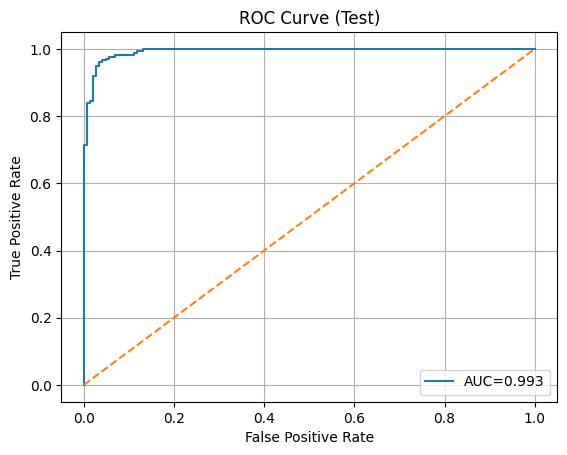

In [18]:
# ROC curve (binary or multi-class)
if NUM_CLASSES == 2:
    fpr, tpr, _ = roc_curve(test_labels_all, test_probs_all[:,1])
    auc = roc_auc_score(test_labels_all, test_probs_all[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1], [0,1], '--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Test)")
    plt.grid(True); plt.legend(); plt.show()
else:
    # One-vs-Rest ROC
    y_bin = label_binarize(test_labels_all, classes=list(range(NUM_CLASSES)))
    aucs = []
    plt.figure()
    for i in range(NUM_CLASSES):
        fpr, tpr, _ = roc_curve(y_bin[:,i], test_probs_all[:,i])
        auc_i = roc_auc_score(y_bin[:,i], test_probs_all[:,i])
        aucs.append(auc_i)
        plt.plot(fpr, tpr, label=f"{IDX_TO_CLASS[i]} (AUC={auc_i:.3f})")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("Multi-class ROC Curve (OvR)"); plt.grid(True); plt.legend(); plt.show()
    print("Per-class AUCs:", {IDX_TO_CLASS[i]: f"{aucs[i]:.3f}" for i in range(NUM_CLASSES)})


Computing t-SNE on TEST features...


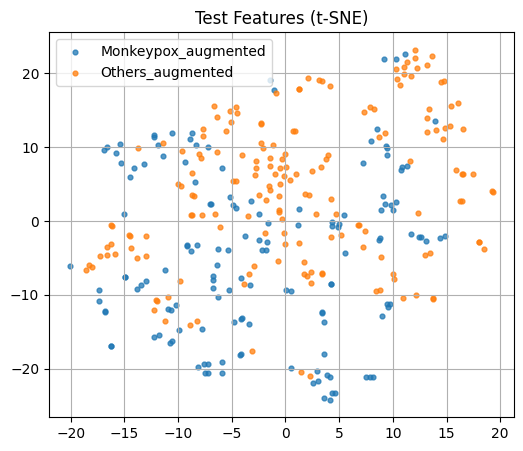

In [19]:
# t-SNE on TEST features (visual check of separability)
print("Computing t-SNE on TEST features...")
test_features, test_labels_for_vis = extract_features(test_loader, encoder_linear)
tsne_test = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30, random_state=SEED)
tsne_test_2d = tsne_test.fit_transform(test_features)
plt.figure(figsize=(6,5))
for c in np.unique(test_labels_for_vis):
    idx = test_labels_for_vis == c
    plt.scatter(tsne_test_2d[idx,0], tsne_test_2d[idx,1], s=12, label=IDX_TO_CLASS[c], alpha=0.75)
plt.legend(); plt.title("Test Features (t-SNE)"); plt.grid(True); plt.show()